# 1. Setup and Configuration

    Imports and Settings

    Helper Functions
    
    Database Connection

In [2]:
# Essential imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import os
import json
from IPython.display import display, HTML

# Optional: Set prettier defaults for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

# Database connection function
def get_db_connection(db_path='../../data/database/football_data.db'):
    """Establish a connection to the SQLite database with row factory enabled."""
    conn = sqlite3.connect(db_path)
    conn.row_factory = sqlite3.Row
    return conn

# Helper function to execute queries and return pandas DataFrames
def execute_query(query, conn=None, close_conn=False):
    """Execute SQL query and return results as a pandas DataFrame."""
    if conn is None:
        conn = get_db_connection()
        close_conn = True  # Close connection if we opened it
        
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        print(f"Query: {query}")
        return pd.DataFrame()  # Return empty dataframe on error
    finally:
        if close_conn and conn:
            conn.close()

# Helper to create section headers in the notebook
def display_section_header(title, level=1):
    """Display formatted section header for better notebook organization."""
    if level == 1:
        display(HTML(f"<h1 style='color:#1E88E5'>{title}</h1>"))
    elif level == 2:
        display(HTML(f"<h2 style='color:#43A047'>{title}</h2>"))
    else:
        display(HTML(f"<h3 style='color:#FB8C00'>{title}</h3>"))

In [3]:
import os
print(os.getcwd())

c:\Users\ADMIN\OneDrive\3_Business\Foot_ball_Data_Retriev\src\utils


# 2. Database Overview

│   ├── Table Summary

│   └── Schema Inspection

In [4]:
def get_database_overview(conn=None):
    """Display tables in the database and their row counts."""
    close_conn = False
    if conn is None:
        conn = get_db_connection()
        close_conn = True
    
    cursor = conn.cursor()

    # Get list of tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in cursor.fetchall()]
    
    overview = []
    for table in tables:
        try:
            cursor.execute(f"SELECT COUNT(*) FROM {table};")
            count = cursor.fetchone()[0]
            
            # Get column info
            cursor.execute(f"PRAGMA table_info({table});")
            columns = cursor.fetchall()
            column_count = len(columns)
            
            # Get primary key info
            primary_key_columns = [col[1] for col in columns if col[5] > 0]  # col[5] > 0 means part of primary key
            
            overview.append({
                'Table': table,
                'Rows': count,
                'Columns': column_count,
                'Primary Key': ', '.join(primary_key_columns) if primary_key_columns else 'None'
            })
        except Exception as e:
            overview.append({
                'Table': table,
                'Rows': f"Error: {e}",
                'Columns': 'N/A',
                'Primary Key': 'N/A'
            })
    
    if close_conn:
        conn.close()
    
    return pd.DataFrame(overview)

# Execute the function
db_overview = get_database_overview()
display(db_overview)

,Table,Rows,Columns,Primary Key
0,leagues,25,13,league_id
1,teams,2508,11,team_id
2,sqlite_sequence,2,2,None
3,seasons,26,12,season_id
4,schedules,6698,15,fixture_id
5,fixture_stats,17940,42,id
6,fixture_odds,154371,22,id


# 3. Foundational Coverage & Completeness

│   ├── 3.1 Overall Fixture Ingestion

│   ├── 3.2 Stats Record Availability

│   ├── 3.3 Critical Period Coverage

│   ├── 3.4 Team Coverage

│   ├── 3.5 Required Stats Completeness

│   └── 3.6 Home/Away Balance

,season_id,league_name,season_name,fixture_count
0,23672,Championship,2024/2025,552
1,23676,La Liga 2,2024/2025,462
2,23614,Premier League,2024/2025,380
3,23621,La Liga,2024/2025,380
4,23746,Serie A,2024/2025,380
5,23839,Serie B,2024/2025,380
6,23851,Super Lig,2024/2025,342
7,23589,Pro League,2024/2025,312
8,23578,Ekstraklasa,2024/2025,306
9,23628,Eredivisie,2024/2025,306


Total fixtures in database: 6698
Average fixtures per season: 304.45
Median fixtures per season: 306.00


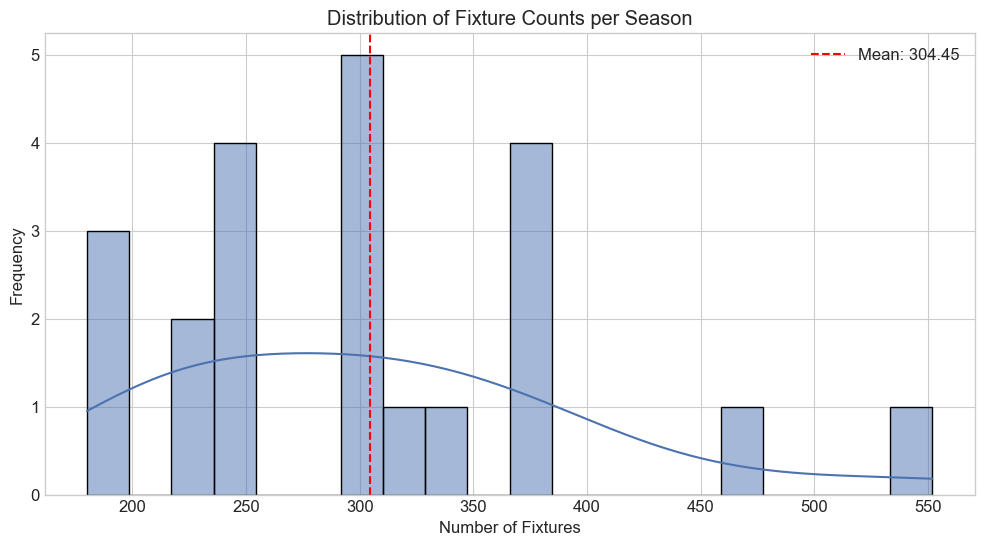

In [5]:
# Get scheduled fixture counts per season and league
season_fixture_counts = execute_query("""
    SELECT 
        s.season_id,
        l.name AS league_name,
        se.name AS season_name,
        COUNT(*) AS fixture_count
    FROM schedules s
    LEFT JOIN leagues l ON s.league_id = l.league_id
    LEFT JOIN seasons se ON s.season_id = se.season_id
    GROUP BY s.season_id, l.name, se.name
    ORDER BY fixture_count DESC
""")

# Display the top leagues by fixture count
display(season_fixture_counts.head(15))

# Calculate some basic statistics
total_fixtures = season_fixture_counts['fixture_count'].sum()
avg_fixtures_per_season = season_fixture_counts['fixture_count'].mean()
median_fixtures_per_season = season_fixture_counts['fixture_count'].median()

print(f"Total fixtures in database: {total_fixtures}")
print(f"Average fixtures per season: {avg_fixtures_per_season:.2f}")
print(f"Median fixtures per season: {median_fixtures_per_season:.2f}")

# Visualize fixture distribution across seasons
plt.figure(figsize=(12, 6))
sns.histplot(season_fixture_counts['fixture_count'], bins=20, kde=True)
plt.title('Distribution of Fixture Counts per Season')
plt.xlabel('Number of Fixtures')
plt.ylabel('Frequency')
plt.axvline(avg_fixtures_per_season, color='red', linestyle='--', label=f'Mean: {avg_fixtures_per_season:.2f}')
plt.legend()
plt.show()

# Check for major leagues with suspiciously low fixture counts (potentially incomplete)
low_count_threshold = 30  # Adjust based on knowledge of league formats
low_count_leagues = season_fixture_counts[
    (season_fixture_counts['fixture_count'] < low_count_threshold) & 
    (season_fixture_counts['league_name'].notnull())
]

if not low_count_leagues.empty:
    print("\nPotentially incomplete leagues (low fixture counts):")
    display(low_count_leagues)

In [6]:
# Query to find 'Finished' fixtures that lack stats
fixtures_without_stats = execute_query("""
    SELECT 
        s.fixture_id,
        s.league_id,
        l.name AS league_name,
        s.season_id,
        se.name AS season_name,
        s.home_team_id,
        ht.name AS home_team,
        s.away_team_id,
        at.name AS away_team,
        s.start_time,
        s.status
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    LEFT JOIN leagues l ON s.league_id = l.league_id
    LEFT JOIN seasons se ON s.season_id = se.season_id
    LEFT JOIN teams ht ON s.home_team_id = ht.team_id
    LEFT JOIN teams at ON s.away_team_id = at.team_id
    WHERE 
        s.status = 'FT' 
        AND fs.fixture_id IS NULL
    ORDER BY s.start_time DESC
""")

# Display summary
total_finished = execute_query("SELECT COUNT(*) AS count FROM schedules WHERE status = 'FT'").iloc[0]['count']
missing_stats_count = len(fixtures_without_stats)
missing_percentage = (missing_stats_count / total_finished * 100) if total_finished > 0 else 0

print(f"Total finished fixtures: {total_finished}")
print(f"Fixtures missing stats: {missing_stats_count} ({missing_percentage:.2f}%)")

# Display sample of fixtures without stats
if not fixtures_without_stats.empty:
    display(fixtures_without_stats.head(100))
    
    # Group by league to see if some leagues are systematically missing stats
    missing_by_league = fixtures_without_stats.groupby(['league_name'])['fixture_id'].count().reset_index()
    missing_by_league.columns = ['League', 'Fixtures Missing Stats']
    missing_by_league = missing_by_league.sort_values('Fixtures Missing Stats', ascending=False)
    
    print("\nLeagues with most fixtures missing stats:")
    display(missing_by_league.head(10))

Total finished fixtures: 5449
Fixtures missing stats: 532 (9.76%)


,fixture_id,league_id,league_name,season_id,season_name,home_team_id,home_team,away_team_id,away_team,start_time,status
0,19145047,567,La Liga 2,23676,2024/2025,60,SD Eibar,126,Málaga,2025-04-21 18:30:00,FT
1,19144091,9,Championship,23672,2024/2025,22,Hull City,99,Preston North End,2025-04-21 14:00:00,FT
2,19144093,9,Championship,23672,2024/2025,71,Leeds United,26,Stoke City,2025-04-21 14:00:00,FT
3,19144098,9,Championship,23672,2024/2025,110,Plymouth Argyle,117,Coventry City,2025-04-21 14:00:00,FT
4,19144107,9,Championship,23672,2024/2025,10,West Bromwich Albion,24,Derby County,2025-04-21 14:00:00,FT
5,19155387,384,Serie A,23746,2024/2025,8513,Bologna,2930,Inter,2025-04-20 16:00:00,FT
6,19172296,600,Super Lig,23851,2024/2025,88,Fenerbahçe,643,Kayserispor,2025-04-20 16:00:00,FT
7,19139914,301,Ligue 1,23643,2024/2025,450,Nice,776,Angers SCO,2025-04-20 15:15:00,FT
8,19139919,301,Ligue 1,23643,2024/2025,1028,Reims,289,Toulouse,2025-04-20 15:15:00,FT
9,19149045,609,None,23703,2024/2025,5562,Veres,6061,Chornomorets,2025-04-20 15:00:00,FT



Leagues with most fixtures missing stats:


,League,Fixtures Missing Stats
11,Premier League,82
4,Championship,64
8,La Liga 2,59
6,Eredivisie,48
7,La Liga,43
14,Serie A,39
10,Ligue 1,38
3,Bundesliga,24
17,Super Lig,23
13,Pro League,21


In [7]:
# Query fixtures that have any stats but are missing first-half stats
fixtures_missing_first_half = execute_query("""
    SELECT 
        fs.fixture_id,
        s.league_id,
        l.name AS league_name,
        s.status,
        GROUP_CONCAT(DISTINCT fs.period) AS available_periods
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
    LEFT JOIN leagues l ON s.league_id = l.league_id
    WHERE fs.fixture_id NOT IN (
        SELECT DISTINCT fixture_id 
        FROM fixture_stats 
        WHERE period = 'first_half'
    )
    GROUP BY fs.fixture_id, s.league_id, l.name, s.status
    ORDER BY fs.fixture_id
""")

total_fixtures_with_stats = execute_query("""
    SELECT COUNT(DISTINCT fixture_id) AS count FROM fixture_stats
""").iloc[0]['count']

missing_first_half_count = len(fixtures_missing_first_half)
missing_percentage = (missing_first_half_count / total_fixtures_with_stats * 100) if total_fixtures_with_stats > 0 else 0

print(f"Total fixtures with any stats: {total_fixtures_with_stats}")
print(f"Fixtures missing first-half stats: {missing_first_half_count} ({missing_percentage:.2f}%)")

if not fixtures_missing_first_half.empty:
    display(fixtures_missing_first_half.head(10))
    
    # Group by available periods to see patterns
    period_patterns = fixtures_missing_first_half['available_periods'].value_counts().reset_index()
    period_patterns.columns = ['Available Periods', 'Count']
    
    print("\nDistribution of available periods (when first_half is missing):")
    display(period_patterns)

Total fixtures with any stats: 4917
Fixtures missing first-half stats: 512 (10.41%)


,fixture_id,league_id,league_name,status,available_periods
0,19129885,244,1. HNL,FT,second_half
1,19129891,244,1. HNL,FT,second_half
2,19129895,244,1. HNL,FT,second_half
3,19129897,244,1. HNL,FT,second_half
4,19129898,244,1. HNL,FT,second_half
5,19129900,244,1. HNL,FT,second_half
6,19129905,244,1. HNL,FT,second_half
7,19129906,244,1. HNL,FT,second_half
8,19129907,244,1. HNL,FT,second_half
9,19129913,244,1. HNL,FT,second_half



Distribution of available periods (when first_half is missing):


,Available Periods,Count
0,second_half,512


In [8]:
# Check team coverage for first_half period
team_coverage = execute_query("""
    SELECT 
        fixture_id,
        COUNT(DISTINCT team_id) AS team_count
    FROM fixture_stats
    WHERE period = 'first_half'
    GROUP BY fixture_id
    HAVING team_count != 2  -- We want exactly 2 teams
    ORDER BY team_count
""")

total_fixtures_first_half = execute_query("""
    SELECT COUNT(DISTINCT fixture_id) AS count 
    FROM fixture_stats 
    WHERE period = 'first_half'
""").iloc[0]['count']

incomplete_teams_count = len(team_coverage)
incomplete_percentage = (incomplete_teams_count / total_fixtures_first_half * 100) if total_fixtures_first_half > 0 else 0

print(f"Total fixtures with first-half stats: {total_fixtures_first_half}")
print(f"Fixtures with incomplete team coverage: {incomplete_teams_count} ({incomplete_percentage:.2f}%)")

if not team_coverage.empty:
    print("\nFixtures with abnormal team count (not exactly 2 teams):")
    display(team_coverage)
    
    # Get details for a sample of these fixtures
    if not team_coverage.empty:
        sample_ids = tuple(team_coverage['fixture_id'].head(5).tolist())
        
        # Handle case of single ID differently (SQL syntax)
        if len(sample_ids) == 1:
            sample_ids = f"({sample_ids[0]})"
        
        sample_details = execute_query(f"""
            SELECT 
                fs.fixture_id,
                fs.team_id,
                t.name AS team_name,
                fs.period,
                s.home_team_id,
                s.away_team_id
            FROM fixture_stats fs
            JOIN schedules s ON fs.fixture_id = s.fixture_id
            LEFT JOIN teams t ON fs.team_id = t.team_id
            WHERE fs.fixture_id IN {sample_ids}
            ORDER BY fs.fixture_id, fs.team_id
        """)
        
        print("\nSample details for fixtures with abnormal team count:")
        display(sample_details)

Total fixtures with first-half stats: 4405
Fixtures with incomplete team coverage: 1 (0.02%)

Fixtures with abnormal team count (not exactly 2 teams):


,fixture_id,team_count
0,19172176,1



Sample details for fixtures with abnormal team count:


,fixture_id,team_id,team_name,period,home_team_id,away_team_id
0,19172176,88,Fenerbahçe,first_half,2632,88


Total first-half stat records: 8809

NULL Value Analysis for Required Statistics:


,Statistic,NULL Count,NULL %
2,red_cards,5397,61.27
0,goals,2203,25.01
4,shots_blocked,990,11.24
7,saves,903,10.25
10,shots_insidebox,645,7.32
3,tackles,467,5.30
5,successful_passes_percentage,390,4.43
9,shots_total,218,2.47
1,fouls,103,1.17
8,attacks,68,0.77


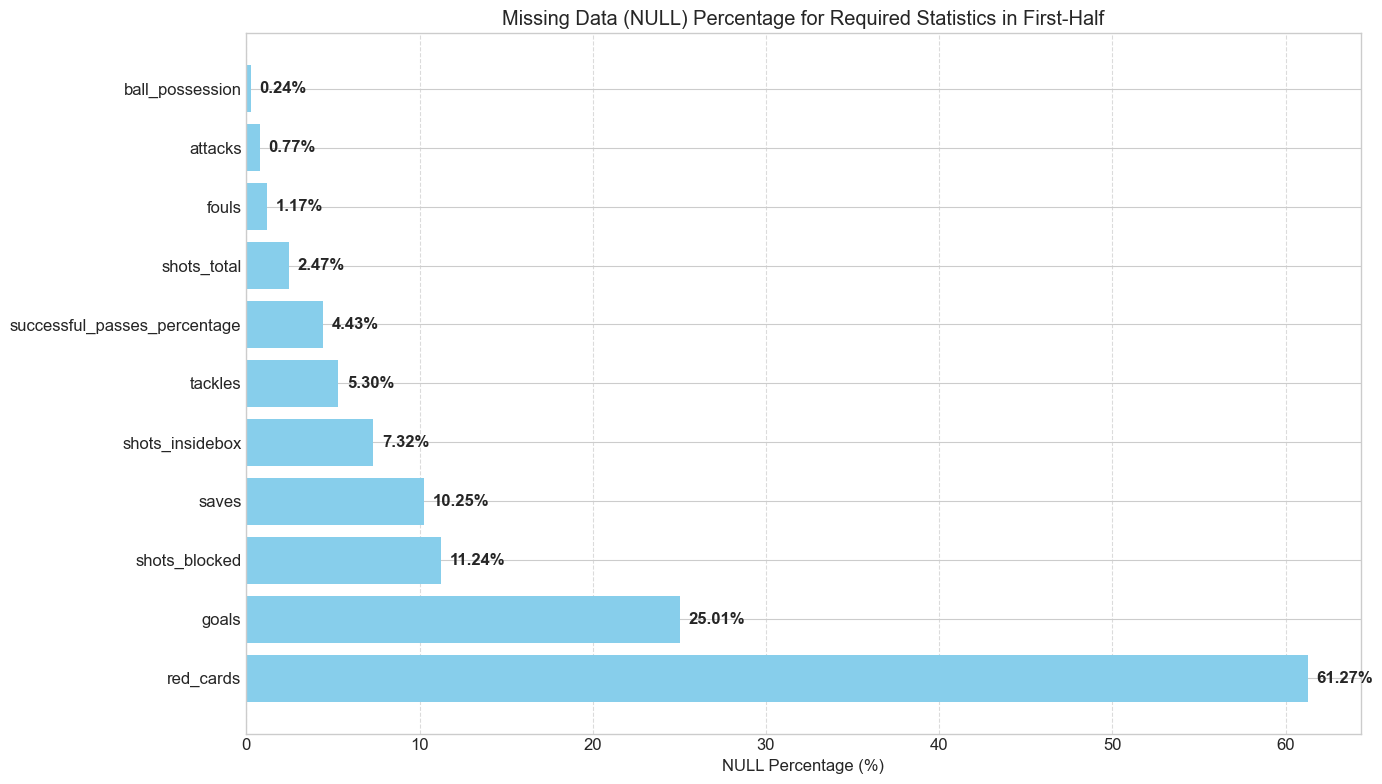


Fixtures with ALL required stats NULL for first-half: 0


In [9]:
# List of required columns for half-time modeling
required_stats_cols = [
    "goals", "fouls", "red_cards", "tackles", "shots_blocked",
    "successful_passes_percentage", "ball_possession", "saves",
    "attacks", "shots_total", "shots_insidebox"
]

# Build the query dynamically to check NULL percentage for each column
null_check_parts = []
for col in required_stats_cols:
    null_check_parts.append(f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_null_count")
    null_check_parts.append(f"ROUND(SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS {col}_null_percent")

query = f"""
    SELECT 
        COUNT(*) AS total_records,
        {', '.join(null_check_parts)}
    FROM fixture_stats
    WHERE period = 'first_half'
"""

null_stats = execute_query(query)

# Format into a more readable DataFrame
null_analysis = pd.DataFrame({
    'Statistic': required_stats_cols,
    'NULL Count': [null_stats[f"{col}_null_count"].iloc[0] for col in required_stats_cols],
    'NULL %': [null_stats[f"{col}_null_percent"].iloc[0] for col in required_stats_cols]
})

# Sort by NULL percentage (descending)
null_analysis = null_analysis.sort_values('NULL %', ascending=False)

print(f"Total first-half stat records: {null_stats['total_records'].iloc[0]}")
print("\nNULL Value Analysis for Required Statistics:")
display(null_analysis)

# Visualize NULL percentages
plt.figure(figsize=(14, 8))
bars = plt.barh(null_analysis['Statistic'], null_analysis['NULL %'], color='skyblue')
plt.xlabel('NULL Percentage (%)')
plt.title('Missing Data (NULL) Percentage for Required Statistics in First-Half')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels to bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Check for fixtures where ALL required stats are NULL (completely missing data)
all_null_fixtures = execute_query(f"""
    SELECT 
        fs.fixture_id,
        s.home_team_id,
        ht.name AS home_team,
        s.away_team_id,
        at.name AS away_team,
        s.start_time,
        s.status,
        fs.team_id,
        t.name AS team_name
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
    LEFT JOIN teams ht ON s.home_team_id = ht.team_id
    LEFT JOIN teams at ON s.away_team_id = at.team_id
    LEFT JOIN teams t ON fs.team_id = t.team_id
    WHERE 
        fs.period = 'first_half'
        AND {' AND '.join([f"{col} IS NULL" for col in required_stats_cols])}
    ORDER BY s.start_time DESC
""")

print(f"\nFixtures with ALL required stats NULL for first-half: {len(all_null_fixtures)}")
if not all_null_fixtures.empty:
    display(all_null_fixtures.head(10))

Home/Away Balance Analysis (across 373 team-seasons):
Average difference between home/away matches: 0.02
Median difference: 0.00
Maximum difference: 2

Most imbalanced team schedules:


,season_id,season_name,team_id,team_name,home_matches,away_matches,total_matches,balance_diff
0,23617,2024/2025,362,St. Gallen,18,20,38,2
1,23617,2024/2025,2357,Lausanne Sport,20,18,38,2
2,23690,2024/2025,309,Motherwell,18,20,38,2
3,23690,2024/2025,496,St. Mirren,20,18,38,2
4,23672,2024/2025,2,Blackburn Rovers,23,23,46,0
5,23672,2024/2025,3,Sunderland,23,23,46,0
6,23672,2024/2025,5,Portsmouth,23,23,46,0
7,23672,2024/2025,7,Middlesbrough,23,23,46,0
8,23672,2024/2025,10,West Bromwich Albion,23,23,46,0
9,23672,2024/2025,21,Sheffield United,23,23,46,0


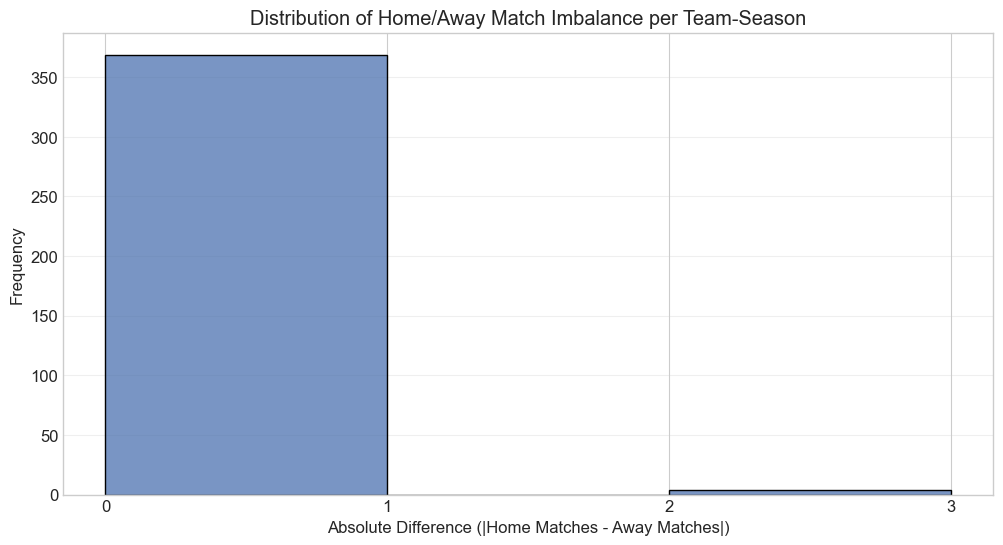

Teams with perfect home/away balance: 369 (98.93%)
Teams with minor imbalance (diff ≤ 2): 373 (100.00%)


In [10]:
# Check home/away balance per team and season
home_away_balance = execute_query("""
    SELECT 
        s.season_id,
        se.name AS season_name,
        t.team_id,
        t.name AS team_name,
        SUM(CASE WHEN s.home_team_id = t.team_id THEN 1 ELSE 0 END) AS home_matches,
        SUM(CASE WHEN s.away_team_id = t.team_id THEN 1 ELSE 0 END) AS away_matches,
        COUNT(*) AS total_matches,
        ABS(SUM(CASE WHEN s.home_team_id = t.team_id THEN 1 ELSE 0 END) - 
            SUM(CASE WHEN s.away_team_id = t.team_id THEN 1 ELSE 0 END)) AS balance_diff
    FROM schedules s
    JOIN teams t ON (t.team_id = s.home_team_id OR t.team_id = s.away_team_id)
    LEFT JOIN seasons se ON s.season_id = se.season_id
    GROUP BY s.season_id, se.name, t.team_id, t.name
    HAVING total_matches >= 10  -- Ignore teams with very few matches
    ORDER BY balance_diff DESC, total_matches DESC
""")

# Calculate summary statistics
avg_diff = home_away_balance['balance_diff'].mean()
median_diff = home_away_balance['balance_diff'].median()
max_diff = home_away_balance['balance_diff'].max()

print(f"Home/Away Balance Analysis (across {len(home_away_balance)} team-seasons):")
print(f"Average difference between home/away matches: {avg_diff:.2f}")
print(f"Median difference: {median_diff:.2f}")
print(f"Maximum difference: {max_diff}")

# Display teams with the most imbalanced schedules
print("\nMost imbalanced team schedules:")
display(home_away_balance.head(10))

# Visualize the distribution of home/away imbalance
plt.figure(figsize=(12, 6))
sns.histplot(home_away_balance['balance_diff'], bins=range(0, int(max_diff) + 2), kde=False)
plt.title('Distribution of Home/Away Match Imbalance per Team-Season')
plt.xlabel('Absolute Difference (|Home Matches - Away Matches|)')
plt.ylabel('Frequency')
plt.xticks(range(0, int(max_diff) + 2))
plt.grid(axis='y', alpha=0.3)
plt.show()

# Calculate percentage of teams with perfect balance or minor imbalance
perfect_balance = (home_away_balance['balance_diff'] == 0).sum()
minor_imbalance = (home_away_balance['balance_diff'] <= 2).sum()

perfect_pct = perfect_balance / len(home_away_balance) * 100
minor_pct = minor_imbalance / len(home_away_balance) * 100

print(f"Teams with perfect home/away balance: {perfect_balance} ({perfect_pct:.2f}%)")
print(f"Teams with minor imbalance (diff ≤ 2): {minor_imbalance} ({minor_pct:.2f}%)")

4. Technical Integrity & Schema Validation

│   ├── 4.1 ID Consistency

│   ├── 4.2 Duplicate Entry Detection

│   ├── 4.3 Schema Consistency

│   └── 4.4 Timestamp Validity

In [11]:
# Check fixture_id consistency between schedules and fixture_stats
fixture_id_consistency = execute_query("""
    SELECT 
        'fixture_stats' AS table_name,
        COUNT(DISTINCT fs.fixture_id) AS unique_fixture_ids,
        SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) AS orphaned_ids,
        ROUND(SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) * 100.0 / 
              COUNT(DISTINCT fs.fixture_id), 2) AS orphaned_percent
    FROM 
        (SELECT DISTINCT fixture_id FROM fixture_stats) fs
    LEFT JOIN 
        schedules s ON fs.fixture_id = s.fixture_id
    
    UNION ALL
    
    SELECT 
        'fixture_odds' AS table_name,
        COUNT(DISTINCT fo.fixture_id) AS unique_fixture_ids,
        SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) AS orphaned_ids,
        ROUND(SUM(CASE WHEN s.fixture_id IS NULL THEN 1 ELSE 0 END) * 100.0 / 
              COUNT(DISTINCT fo.fixture_id), 2) AS orphaned_percent
    FROM 
        (SELECT DISTINCT fixture_id FROM fixture_odds) fo
    LEFT JOIN 
        schedules s ON fo.fixture_id = s.fixture_id
""")

print("Fixture ID Consistency Check:")
display(fixture_id_consistency)

# Check team_id consistency between fixture_stats and schedules
team_id_consistency = execute_query("""
    SELECT 
        COUNT(DISTINCT fs.fixture_id) AS fixtures_checked,
        SUM(CASE 
            WHEN fs.team_id != s.home_team_id AND fs.team_id != s.away_team_id 
            THEN 1 ELSE 0 
        END) AS inconsistent_team_ids,
        ROUND(SUM(CASE 
            WHEN fs.team_id != s.home_team_id AND fs.team_id != s.away_team_id 
            THEN 1 ELSE 0 
        END) * 100.0 / COUNT(*), 2) AS inconsistent_percent
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
""")

print("\nTeam ID Consistency Check:")
display(team_id_consistency)

# If inconsistencies found, display some examples
if team_id_consistency['inconsistent_team_ids'].iloc[0] > 0:
    inconsistent_examples = execute_query("""
        SELECT 
            fs.fixture_id,
            fs.team_id AS stats_team_id,
            t_stats.name AS stats_team_name,
            s.home_team_id,
            t_home.name AS home_team_name,
            s.away_team_id,
            t_away.name AS away_team_name
        FROM fixture_stats fs
        JOIN schedules s ON fs.fixture_id = s.fixture_id
        LEFT JOIN teams t_stats ON fs.team_id = t_stats.team_id
        LEFT JOIN teams t_home ON s.home_team_id = t_home.team_id
        LEFT JOIN teams t_away ON s.away_team_id = t_away.team_id
        WHERE 
            fs.team_id != s.home_team_id AND 
            fs.team_id != s.away_team_id
        LIMIT 10
    """)
    
    print("\nExamples of team ID inconsistencies:")
    display(inconsistent_examples)

Fixture ID Consistency Check:


,table_name,unique_fixture_ids,orphaned_ids,orphaned_percent
0,fixture_stats,4917,0,0.0
1,fixture_odds,5448,0,0.0



Team ID Consistency Check:


,fixtures_checked,inconsistent_team_ids,inconsistent_percent
0,4917,0,0.0


In [12]:
# Check for duplicates in fixture_stats
duplicate_stats = execute_query("""
    SELECT 
        fixture_id, 
        team_id, 
        period, 
        COUNT(*) AS duplicate_count
    FROM fixture_stats
    GROUP BY fixture_id, team_id, period
    HAVING COUNT(*) > 1
    ORDER BY duplicate_count DESC
""")

if len(duplicate_stats) > 0:
    print(f"Found {len(duplicate_stats)} sets of duplicate entries in fixture_stats:")
    display(duplicate_stats)
    
    # Get a sample of the actual duplicate records
    if not duplicate_stats.empty:
        sample_fixture = duplicate_stats.iloc[0]['fixture_id']
        sample_team = duplicate_stats.iloc[0]['team_id']
        sample_period = duplicate_stats.iloc[0]['period']
        
        sample_duplicates = execute_query(f"""
            SELECT *
            FROM fixture_stats
            WHERE 
                fixture_id = {sample_fixture} AND
                team_id = {sample_team} AND
                period = '{sample_period}'
            ORDER BY id
        """)
        
        print(f"\nSample duplicates for fixture_id={sample_fixture}, team_id={sample_team}, period='{sample_period}':")
        display(sample_duplicates)
else:
    print("No duplicates found in fixture_stats based on (fixture_id, team_id, period).")

# Check for duplicates in fixture_odds if the table exists
try:
    duplicate_odds = execute_query("""
        SELECT 
            fixture_id, 
            market_id, 
            bookmaker_id, 
            label,
            value,
            handicap,
            COUNT(*) AS duplicate_count
        FROM fixture_odds
        GROUP BY fixture_id, market_id, bookmaker_id, label, value, handicap
        HAVING COUNT(*) > 1
        ORDER BY duplicate_count DESC
    """)
    
    if len(duplicate_odds) > 0:
        print(f"\nFound {len(duplicate_odds)} sets of duplicate entries in fixture_odds:")
        display(duplicate_odds)
    else:
        print("\nNo duplicates found in fixture_odds based on (fixture_id, market_id, bookmaker_id, label, value, handicap).")
except:
    print("\nCould not check fixture_odds table (may not exist).")

No duplicates found in fixture_stats based on (fixture_id, team_id, period).

No duplicates found in fixture_odds based on (fixture_id, market_id, bookmaker_id, label, value, handicap).


In [13]:
# Function to check if table columns match the expected schema
def check_schema_consistency(conn=None):
    """Check if database tables have all expected columns defined in data/storage.py."""
    close_conn = False
    if conn is None:
        conn = get_db_connection()
        close_conn = True
    
    # Expected columns based on data/storage.py definitions
    # Note: This is simplified for the notebook - in reality, you'd import these from the actual module
    expected_schemas = {
        'leagues': [
            'league_id', 'sport_id', 'country_id', 'name', 'active', 'short_code', 
            'image_path', 'type', 'sub_type', 'last_played_at', 'category', 
            'current_season_id', 'created_at', 'updated_at'
        ],
        'seasons': [
            'season_id', 'league_id', 'league_name', 'sport_id', 'name', 'is_current', 
            'finished', 'pending', 'starting_at', 'ending_at', 
            'standings_recalculated_at', 'created_at', 'updated_at'
        ],
        'teams': [
            'team_id', 'name', 'short_code', 'country_id', 'logo_url', 'venue_id',
            'founded', 'type', 'national_team', 'created_at', 'updated_at'
        ],
        'schedules': [
            'fixture_id', 'season_id', 'league_id', 'round_id', 'home_team_id', 
            'away_team_id', 'start_time', 'status', 'home_score', 'away_score', 
            'result', 'result_info', 'round_finished', 'created_at', 'updated_at'
        ],
        'fixture_stats': [
            'id', 'fixture_id', 'team_id', 'period', 'goals', 'shots_on_target', 
            'shots_off_target', 'ball_possession', 'corners', 'fouls', 'yellow_cards', 
            'red_cards', 'shots_total', 'shots_blocked', 'offsides', 'saves', 
            'hit_woodwork', 'shots_insidebox', 'successful_dribbles', 
            'successful_dribbles_percentage', 'successful_passes', 
            'successful_passes_percentage', 'shots_outsidebox', 'dribble_attempts', 
            'throwins', 'assists', 'accurate_crosses', 'total_crosses', 'penalties', 
            'passes', 'attacks', 'challenges', 'tackles', 'interceptions', 
            'long_passes', 'goal_kicks', 'key_passes', 'dangerous_attacks', 
            'substitutions', 'timestamp', 'created_at', 'updated_at'
        ],
        'fixture_odds': [
            'id', 'fixture_id', 'market_id', 'bookmaker_id', 'label', 'name',
            'market_description', 'value', 'probability', 'dp3', 'fractional',
            'american', 'winning', 'stopped', 'total', 'handicap', 'participants',
            'api_created_at', 'original_label', 'latest_bookmaker_update', 
            'created_at', 'updated_at'
        ]
    }
    
    results = []
    cursor = conn.cursor()
    
    for table, expected_columns in expected_schemas.items():
        try:
            # Get actual columns from database
            cursor.execute(f"PRAGMA table_info({table});")
            actual_columns = [row[1] for row in cursor.fetchall()]
            
            # Find missing and extra columns
            missing_columns = [col for col in expected_columns if col not in actual_columns]
            extra_columns = [col for col in actual_columns if col not in expected_columns]
            
            results.append({
                'Table': table,
                'Expected_Column_Count': len(expected_columns),
                'Actual_Column_Count': len(actual_columns),
                'Missing_Columns': ', '.join(missing_columns) if missing_columns else 'None',
                'Extra_Columns': ', '.join(extra_columns) if extra_columns else 'None',
                'Is_Consistent': len(missing_columns) == 0,
                'Status': 'Present' if len(actual_columns) > 0 else 'Missing'
            })
        except:
            results.append({
                'Table': table,
                'Expected_Column_Count': len(expected_columns),
                'Actual_Column_Count': 0,
                'Missing_Columns': 'Table not found',
                'Extra_Columns': 'N/A',
                'Is_Consistent': False,
                'Status': 'Missing'
            })
    
    if close_conn:
        conn.close()
    
    return pd.DataFrame(results)

# Execute the function
schema_consistency = check_schema_consistency()
display(schema_consistency)

# Highlight any inconsistencies
inconsistent_tables = schema_consistency[~schema_consistency['Is_Consistent']]
if not inconsistent_tables.empty:
    print("\nTables with schema inconsistencies:")
    display(inconsistent_tables)
else:
    print("\nAll existing tables have consistent schemas as defined in data/storage.py")

,Table,Expected_Column_Count,Actual_Column_Count,Missing_Columns,Extra_Columns,Is_Consistent,Status
0,leagues,14,13,current_season_id,None,False,Present
1,seasons,13,12,league_name,None,False,Present
2,teams,11,11,None,None,True,Present
3,schedules,15,15,None,None,True,Present
4,fixture_stats,42,42,None,None,True,Present
5,fixture_odds,22,22,None,None,True,Present



Tables with schema inconsistencies:


,Table,Expected_Column_Count,Actual_Column_Count,Missing_Columns,Extra_Columns,Is_Consistent,Status
0,leagues,14,13,current_season_id,None,False,Present
1,seasons,13,12,league_name,None,False,Present


,table_name,total_rows,null_created_at,null_updated_at,illogical_timestamps,earliest_created,latest_created,earliest_updated,latest_updated
0,leagues,25,0,0,0,2025-04-12 15:42:43,2025-04-12 15:42:43,2025-04-12 15:42:43,2025-04-12 15:42:43
1,seasons,26,0,0,0,2025-04-16 03:09:26,2025-04-16 03:09:26,2025-04-16 03:09:26,2025-04-16 03:09:26
2,teams,2508,0,0,0,2025-04-12 16:27:39,2025-04-12 16:27:39,2025-04-12 16:27:39,2025-04-12 16:27:39
3,schedules,6698,0,0,0,2025-04-23 14:48:43,2025-04-23 14:49:23,2025-04-23 14:48:43,2025-04-23 14:49:23
4,fixture_stats,17940,0,0,0,2025-04-24 04:17:24,2025-04-24 07:44:16,2025-04-24 04:17:24,2025-04-24 07:44:16
5,fixture_odds,154371,0,0,0,2025-04-24 04:17:13,2025-04-24 09:55:58,2025-04-24 04:17:13,2025-04-24 09:55:58



No timestamp issues found across tables.

Fixture_stats specialized timestamp field analysis:


,total_rows,null_timestamps,earliest_timestamp,latest_timestamp
0,17940,0,2025-04-24T11:16:24.264202,2025-04-24T14:44:16.612751


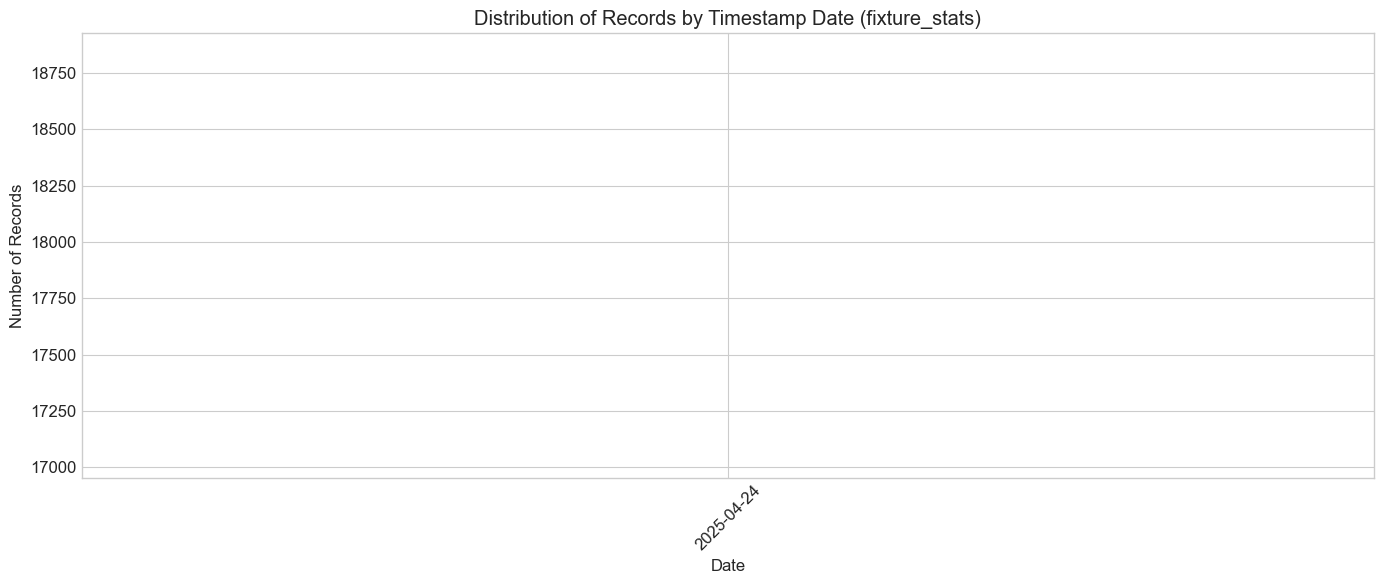

In [14]:
# Check timestamp validity across tables
def check_timestamp_validity(conn=None):
    """Check that created_at and updated_at timestamps are logical."""
    close_conn = False
    if conn is None:
        conn = get_db_connection()
        close_conn = True
    
    # Tables to check (those with timestamp columns)
    tables = ['leagues', 'seasons', 'teams', 'schedules', 'fixture_stats', 'fixture_odds']
    results = []
    
    for table in tables:
        try:
            # Query to check for timestamp issues
            query = f"""
                SELECT 
                    '{table}' AS table_name,
                    COUNT(*) AS total_rows,
                    SUM(CASE WHEN created_at IS NULL THEN 1 ELSE 0 END) AS null_created_at,
                    SUM(CASE WHEN updated_at IS NULL THEN 1 ELSE 0 END) AS null_updated_at,
                    SUM(CASE WHEN updated_at < created_at THEN 1 ELSE 0 END) AS illogical_timestamps,
                    MIN(created_at) AS earliest_created,
                    MAX(created_at) AS latest_created,
                    MIN(updated_at) AS earliest_updated,
                    MAX(updated_at) AS latest_updated
                FROM {table}
            """
            
            df = execute_query(query, conn)
            if not df.empty:
                results.append(df.iloc[0].to_dict())
            
        except Exception as e:
            # Table might not exist or doesn't have timestamp columns
            results.append({
                'table_name': table,
                'total_rows': 0,
                'null_created_at': 0,
                'null_updated_at': 0,
                'illogical_timestamps': 0,
                'earliest_created': None,
                'latest_created': None,
                'earliest_updated': None,
                'latest_updated': None
            })
    
    if close_conn:
        conn.close()
    
    return pd.DataFrame(results)

# Execute the function
timestamp_validity = check_timestamp_validity()
display(timestamp_validity)

# Highlight any tables with timestamp issues
tables_with_issues = timestamp_validity[
    (timestamp_validity['null_created_at'] > 0) | 
    (timestamp_validity['null_updated_at'] > 0) | 
    (timestamp_validity['illogical_timestamps'] > 0)
]

if not tables_with_issues.empty:
    print("\nTables with timestamp issues:")
    display(tables_with_issues)
else:
    print("\nNo timestamp issues found across tables.")

# For fixture_stats specifically, check 'timestamp' field consistency
try:
    stats_timestamp_analysis = execute_query("""
        SELECT 
            COUNT(*) AS total_rows,
            SUM(CASE WHEN timestamp IS NULL THEN 1 ELSE 0 END) AS null_timestamps,
            MIN(timestamp) AS earliest_timestamp,
            MAX(timestamp) AS latest_timestamp
        FROM fixture_stats
    """)
    
    print("\nFixture_stats specialized timestamp field analysis:")
    display(stats_timestamp_analysis)
    
    # Check for suspicious gaps or clusters in timestamps
    timestamp_distribution = execute_query("""
        SELECT 
            DATE(timestamp) AS date,
            COUNT(*) AS records_count
        FROM fixture_stats
        WHERE timestamp IS NOT NULL
        GROUP BY DATE(timestamp)
        ORDER BY DATE(timestamp)
    """)
    
    if not timestamp_distribution.empty:
        # Plot timestamp distribution
        plt.figure(figsize=(14, 6))
        plt.plot(timestamp_distribution['date'], timestamp_distribution['records_count'])
        plt.title('Distribution of Records by Timestamp Date (fixture_stats)')
        plt.xlabel('Date')
        plt.ylabel('Number of Records')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"\nCould not analyze timestamp field in fixture_stats: {e}")

├── 5. Statistical Validity & Consistency

│   ├── 5.1 Value Ranges & Outliers

│   ├── 5.2 Internal Statistical Consistency

│   ├── 5.3 Score Consistency

│   └── 5.4 Temporal Consistency

Statistical description of first-half statistics:


,count,min,max,range,mean,std,25%,50%,75%
goals,6606.0,0.0,6.0,6.0,0.80,0.81,0.0,1.0,1.0
shots_on_target,6431.0,0.0,10.0,10.0,2.13,1.51,1.0,2.0,3.0
shots_off_target,6357.0,0.0,12.0,12.0,2.32,1.59,1.0,2.0,3.0
shots_total,6541.0,0.0,23.0,23.0,5.81,3.09,4.0,5.0,8.0
ball_possession,6601.0,0.0,100.0,100.0,68.99,21.15,52.0,65.0,88.0
corners,6399.0,0.0,12.0,12.0,2.32,1.77,1.0,2.0,3.0
fouls,6588.0,0.0,20.0,20.0,5.57,2.56,4.0,5.0,7.0
yellow_cards,5446.0,0.0,6.0,6.0,0.85,0.85,0.0,1.0,1.0
red_cards,3344.0,0.0,2.0,2.0,0.05,0.22,0.0,0.0,0.0
passes,6351.0,0.0,587.0,587.0,213.24,67.54,167.0,207.0,255.0



Extreme outliers for goals:
  Lower bound: -3.0
  Upper bound: 4.0
  Outlier values: [np.int64(5), np.int64(6)]
  Outlier count: 8

Extreme outliers for shots_on_target:
  Lower bound: -5.0
  Upper bound: 9.0
  Outlier values: [np.float64(10.0)]
  Outlier count: 1

Extreme outliers for shots_off_target:
  Lower bound: -5.0
  Upper bound: 9.0
  Outlier values: [np.float64(10.0), np.float64(12.0)]
  Outlier count: 2

Extreme outliers for shots_total:
  Lower bound: -8.0
  Upper bound: 20.0
  Outlier values: [np.float64(23.0)]
  Outlier count: 1

Extreme outliers for corners:
  Lower bound: -5.0
  Upper bound: 9.0
  Outlier values: [np.float64(10.0), np.float64(11.0), np.float64(12.0)]
  Outlier count: 10

Extreme outliers for fouls:
  Lower bound: -5.0
  Upper bound: 16.0
  Outlier values: [np.float64(17.0), np.float64(18.0), np.float64(20.0)]
  Outlier count: 5

Extreme outliers for yellow_cards:
  Lower bound: -3.0
  Upper bound: 4.0
  Outlier values: [np.float64(5.0), np.float64(6.0)

,fixture_id,team_id,column,value,lower_bound,upper_bound
0,1.91e+07,890.0,goals,5.0,-3.0,4.0
1,1.91e+07,19.0,goals,5.0,-3.0,4.0
2,1.91e+07,6.0,goals,5.0,-3.0,4.0
3,1.91e+07,83.0,goals,5.0,-3.0,4.0
4,1.91e+07,450.0,goals,6.0,-3.0,4.0
...,...,...,...,...,...,...
235,1.92e+07,345.0,saves,6.0,-2.0,5.0
236,1.92e+07,3224.0,saves,6.0,-2.0,5.0
237,1.92e+07,13924.0,saves,6.0,-2.0,5.0
238,1.91e+07,2938.0,challenges,249.0,-6.0,15.0


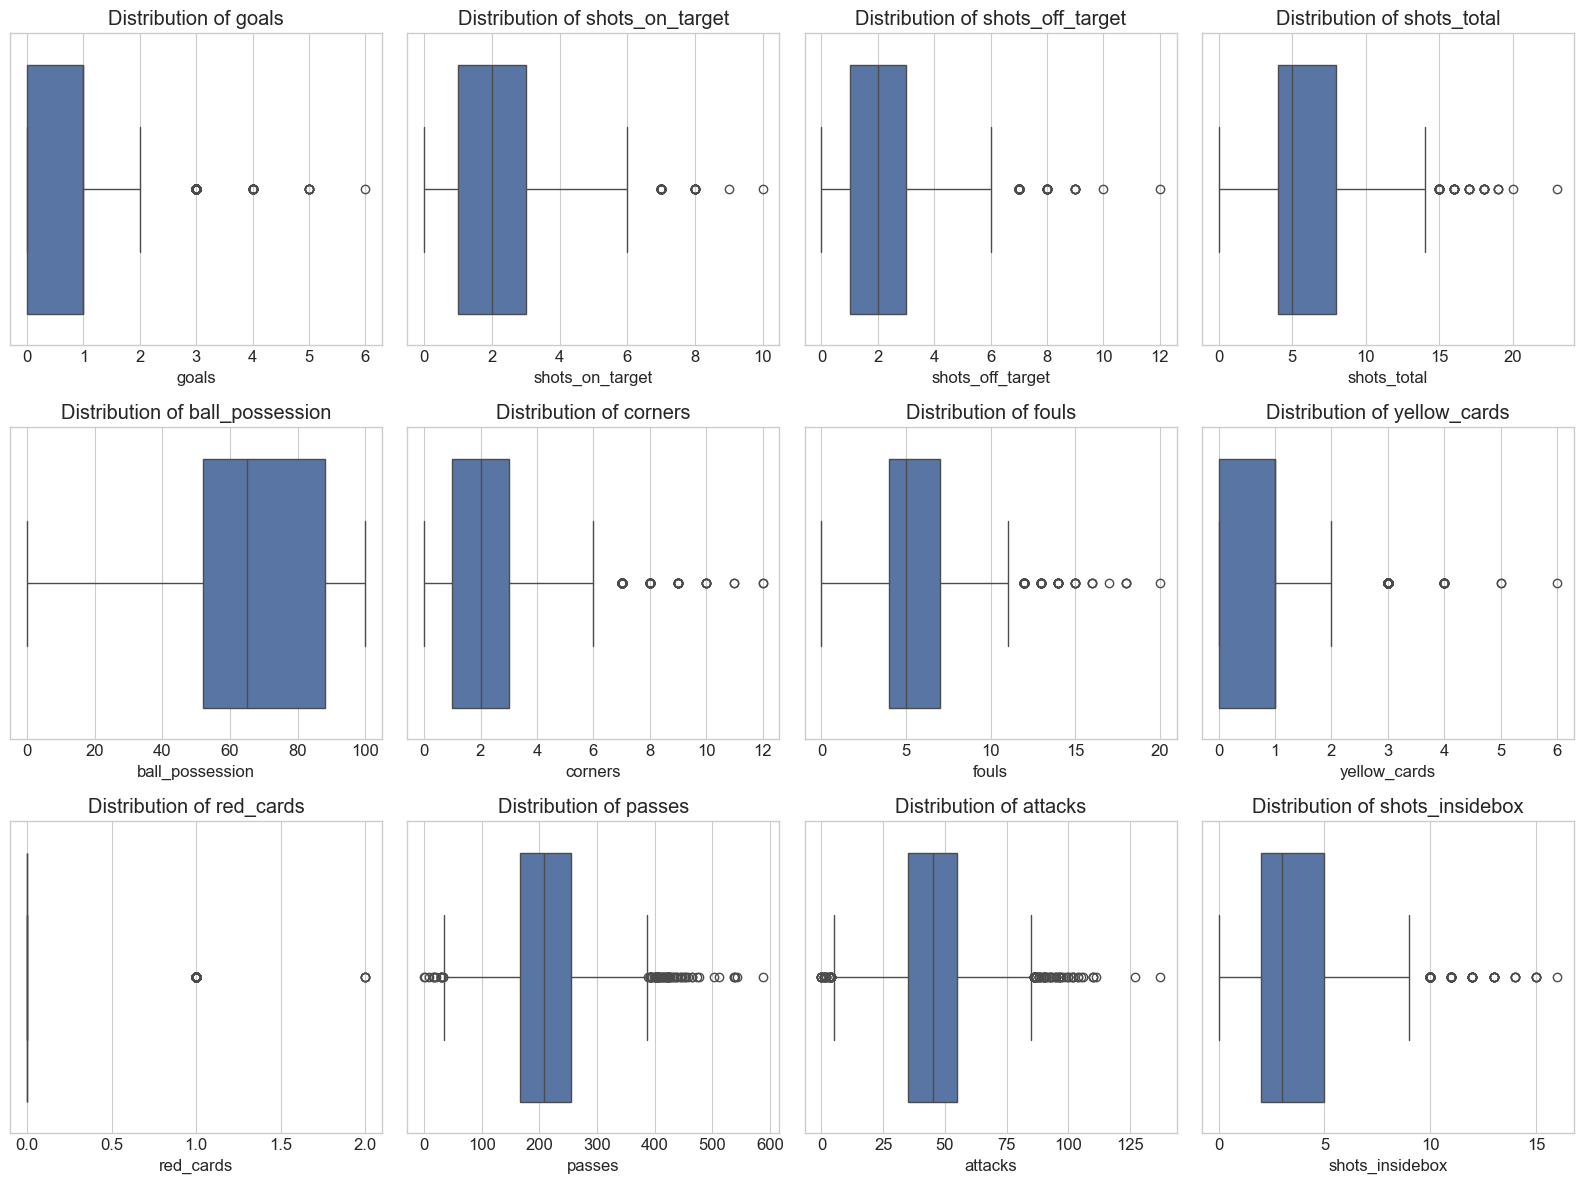

In [15]:
# Get key stats from fixture_stats for first-half period including fixture_id and team_id
stats_data = execute_query("""
    SELECT 
        fixture_id, team_id,
        goals, shots_on_target, shots_off_target, shots_total, 
        ball_possession, corners, fouls, yellow_cards, red_cards,
        passes, attacks, shots_insidebox, saves, challenges
    FROM fixture_stats
    WHERE period = 'first_half'
    AND goals IS NOT NULL  -- Filter out rows with NULL key stats
""")

# Define stats columns (excluding identifier columns)
stats_columns = [col for col in stats_data.columns if col not in ['fixture_id', 'team_id']]

# Basic statistical description
print("Statistical description of first-half statistics:")
stats_description = stats_data[stats_columns].describe().transpose()
stats_description['range'] = stats_description['max'] - stats_description['min']
stats_description = stats_description[['count', 'min', 'max', 'range', 'mean', 'std', '25%', '50%', '75%']]
display(stats_description)

# Identify extreme outliers (beyond 3 IQRs)
all_outliers = []  # Create list to store all outlier records

for column in stats_columns:
    if stats_data[column].dtype in [np.int64, np.float64]:
        Q1 = stats_data[column].quantile(0.25)
        Q3 = stats_data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        col_outliers = stats_data[(stats_data[column] < lower_bound) | (stats_data[column] > upper_bound)]
        
        if not col_outliers.empty:
            # Add each outlier as a record with metadata - now using actual fixture_id and team_id
            for _, row in col_outliers.iterrows():
                all_outliers.append({
                    'fixture_id': row['fixture_id'],  # Using actual fixture_id
                    'team_id': row['team_id'],        # Including team_id for context
                    'column': column,
                    'value': row[column],
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                })
            
            print(f"\nExtreme outliers for {column}:")
            print(f"  Lower bound: {lower_bound}")
            print(f"  Upper bound: {upper_bound}")
            print(f"  Outlier values: {sorted(col_outliers[column].unique())}")
            print(f"  Outlier count: {len(col_outliers)}")

# Convert list to DataFrame after loop
outliers = pd.DataFrame(all_outliers)
if not outliers.empty:
    print("\nSummary of all outliers:")
    display(outliers)

# Plot distributions with boxplots to visualize outliers
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(stats_columns[:12]):  # Limit to 12 plots for readability
    if stats_data[column].dtype in [np.int64, np.float64]:
        ax = axes[i]
        sns.boxplot(x=stats_data[column], ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        
plt.tight_layout()
plt.show()

# Impossible value check
impossible_values = {
    'ball_possession': {'min': 0, 'max': 100},
    'shots_on_target': {'min': 0, 'max': None},
    'shots_total': {'min': 0, 'max': None},
    'goals': {'min': 0, 'max': None},
    'red_cards': {'min': 0, 'max': 11},  # Maximum players on field
    'passes': {'min': 0, 'max': None}
}

for stat, bounds in impossible_values.items():
    if stat in stats_data.columns:
        min_bound = bounds['min']
        max_bound = bounds['max']
        
        conditions = []
        if min_bound is not None:
            conditions.append(f"{stat} < {min_bound}")
        if max_bound is not None:
            conditions.append(f"{stat} > {max_bound}")
        
        if conditions:
            query = f"""
                SELECT 
                    fs.fixture_id,
                    fs.team_id,
                    t.name AS team_name,
                    fs.period,
                    fs.{stat} AS {stat}_value
                FROM fixture_stats fs
                LEFT JOIN teams t ON fs.team_id = t.team_id
                WHERE fs.period = 'first_half'
                AND ({' OR '.join(conditions)})
                ORDER BY fs.{stat}
            """
            
            impossible_records = execute_query(query)
            
            if not impossible_records.empty:
                print(f"\nFound {len(impossible_records)} records with impossible {stat} values:")
                display(impossible_records.head(10))


No violations found for logical relationship: 'shots_total >= shots_on_target'

Found 10 records violating 'goals <= shots_on_target':


,fixture_id,team_id,team_name,period,shots_total,shots_on_target,shots_off_target,shots_blocked,shots_insidebox,goals
0,19129587,8761,Widzew Lodz,first_half,7,2,1,4,3,3
1,19129730,890,Jagiellonia Białystok,first_half,8,0,3,3,5,1
2,19129805,4504,Istra 1961,first_half,8,1,4,3,3,2
3,19129936,7684,Varaždin,first_half,7,0,2,4,5,1
4,19130361,2447,Viborg FF,first_half,0,0,0,0,0,1
5,19131280,1947,OH Leuven,first_half,3,0,2,1,2,1
6,19131334,2402,Gent,first_half,2,1,1,0,2,2
7,19134612,29,Wolverhampton Wanderers,first_half,6,1,3,2,3,2
8,19135369,528,Espanyol,first_half,5,0,2,3,3,1
9,19135384,844,Leganés,first_half,2,0,2,0,0,1



Found 10 records violating 'shots_total >= shots_insidebox':


,fixture_id,team_id,team_name,period,shots_total,shots_on_target,shots_off_target,shots_blocked,shots_insidebox,goals
0,19129741,11356,Motor Lublin,first_half,3,1,2,1.0,4,1
1,19131455,2938,Mechelen,first_half,3,1,2,1.0,4,0
2,19135004,15,Aston Villa,first_half,4,2,1,0.0,5,0
3,19139822,450,Nice,first_half,8,2,4,2.0,9,1
4,19139863,450,Nice,first_half,5,5,0,0.0,6,1
5,19144043,99,Preston North End,first_half,0,0,0,0.0,1,1
6,19144988,126,Málaga,first_half,5,0,3,2.0,6,0
7,19154740,1079,FC Union Berlin,first_half,4,1,4,NaN,5,0
8,19160729,2628,Santa Clara,first_half,1,1,1,0.0,2,1
9,19160762,269225,AVS,first_half,1,1,0,0.0,2,1



Found 10 records violating 'shots_on_target + shots_off_target + shots_blocked <= shots_total':


,fixture_id,team_id,team_name,period,shots_total,shots_on_target,shots_off_target,shots_blocked,shots_insidebox,goals
0,19129491,1266,Zagłębie Lubin,first_half,5,2,2,2,3,2
1,19129498,2764,Katowice,first_half,4,2,2,1,3,1
2,19129508,3191,Radomiak Radom,first_half,6,1,4,2,3,0
3,19129532,11356,Motor Lublin,first_half,12,1,3,9,3,0
4,19129533,1266,Zagłębie Lubin,first_half,4,2,1,2,4,0
5,19129534,3191,Radomiak Radom,first_half,2,1,1,1,2,1
6,19129536,3781,Górnik Zabrze,first_half,5,1,5,0,3,1
7,19129545,808,Pogoń Szczecin,first_half,5,3,2,1,3,0
8,19129546,2764,Katowice,first_half,7,2,2,4,5,2
9,19129552,12038,Puszcza Niepołomice,first_half,1,1,1,0,1,1



Fixtures with possession sum significantly different from 100%:


,fixture_id,team1_id,team1_name,team1_possession,team2_id,team2_name,team2_possession,possession_sum,possession_diff_from_100
0,19129795,3358,Rijeka,95.0,7684,Varaždin,100.0,195.0,95.0
1,19136513,73,Feyenoord,94.0,669,Willem II,100.0,194.0,94.0
2,19136586,494,NEC Nijmegen,94.0,1053,SC Heerenveen,100.0,194.0,94.0
3,19139659,591,Paris Saint Germain,94.0,1055,Le Havre,100.0,194.0,94.0
4,19154762,503,FC Bayern München,93.0,999,VfL Bochum 1848,100.0,193.0,93.0
5,19131313,328,Antwerp,92.0,2938,Mechelen,100.0,192.0,92.0
6,19139655,271,Lens,92.0,776,Angers SCO,100.0,192.0,92.0
7,19142817,25,Watford,100.0,30,Swansea City,92.0,192.0,92.0
8,19134900,19,Arsenal,91.0,116,Ipswich Town,100.0,191.0,91.0
9,19142919,2,Blackburn Rovers,91.0,3,Sunderland,100.0,191.0,91.0


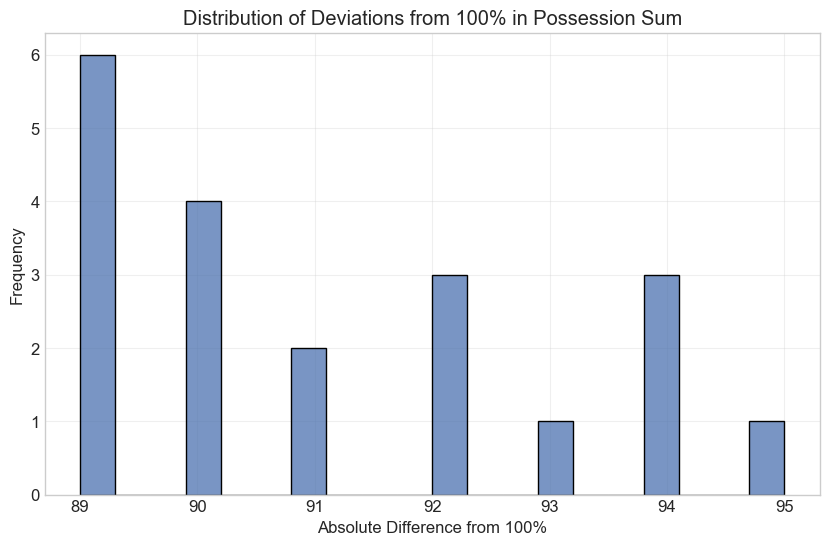

In [16]:
# Define logical relationships to check
logical_checks = [
    {"name": "shots_total >= shots_on_target", 
     "query": "shots_total < shots_on_target"},
    {"name": "goals <= shots_on_target", 
     "query": "goals > shots_on_target"},
    {"name": "shots_total >= shots_insidebox", 
     "query": "shots_total < shots_insidebox"},
    {"name": "shots_on_target + shots_off_target + shots_blocked <= shots_total", 
     "query": "shots_on_target + shots_off_target + shots_blocked > shots_total"}
]

# Check each logical relationship
for check in logical_checks:
    query = f"""
        SELECT 
            fs.fixture_id,
            fs.team_id,
            t.name AS team_name,
            fs.period,
            fs.shots_total,
            fs.shots_on_target,
            fs.shots_off_target,
            fs.shots_blocked,
            fs.shots_insidebox,
            fs.goals
        FROM fixture_stats fs
        LEFT JOIN teams t ON fs.team_id = t.team_id
        WHERE fs.period = 'first_half'
        AND {check['query']}
        AND shots_total IS NOT NULL
        AND shots_on_target IS NOT NULL
        AND shots_insidebox IS NOT NULL
        AND goals IS NOT NULL
        LIMIT 10
    """
    
    inconsistent_records = execute_query(query)
    
    if not inconsistent_records.empty:
        print(f"\nFound {len(inconsistent_records)} records violating '{check['name']}':")
        display(inconsistent_records.head(10))
    else:
        print(f"\nNo violations found for logical relationship: '{check['name']}'")

# Check for pairs of teams in a fixture where ball possession doesn't sum close to 100%
possession_sum_check = execute_query("""
    SELECT 
        t1.fixture_id,
        t1.team_id AS team1_id,
        tm1.name AS team1_name,
        t1.ball_possession AS team1_possession,
        t2.team_id AS team2_id,
        tm2.name AS team2_name,
        t2.ball_possession AS team2_possession,
        (t1.ball_possession + t2.ball_possession) AS possession_sum,
        ABS(t1.ball_possession + t2.ball_possession - 100) AS possession_diff_from_100
    FROM 
        fixture_stats t1
    JOIN 
        fixture_stats t2 ON t1.fixture_id = t2.fixture_id AND t1.team_id < t2.team_id
    LEFT JOIN
        teams tm1 ON t1.team_id = tm1.team_id
    LEFT JOIN
        teams tm2 ON t2.team_id = tm2.team_id
    WHERE 
        t1.period = 'first_half' AND 
        t2.period = 'first_half' AND
        t1.ball_possession IS NOT NULL AND 
        t2.ball_possession IS NOT NULL
    ORDER BY 
        possession_diff_from_100 DESC
    LIMIT 20
""")

if not possession_sum_check.empty:
    print("\nFixtures with possession sum significantly different from 100%:")
    display(possession_sum_check)
    
    # Histogram of possession sum differences
    plt.figure(figsize=(10, 6))
    sns.histplot(possession_sum_check['possession_diff_from_100'], bins=20)
    plt.title('Distribution of Deviations from 100% in Possession Sum')
    plt.xlabel('Absolute Difference from 100%')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("\nNo possession sum inconsistencies found.")

In [17]:
# Compare goal totals between fixture_stats and schedules
score_consistency = execute_query("""
    WITH stat_goals AS (
        SELECT 
            fs.fixture_id,
            s.home_team_id,
            s.away_team_id,
            SUM(CASE WHEN fs.team_id = s.home_team_id THEN fs.goals ELSE 0 END) AS home_goals_from_stats,
            SUM(CASE WHEN fs.team_id = s.away_team_id THEN fs.goals ELSE 0 END) AS away_goals_from_stats
        FROM fixture_stats fs
        JOIN schedules s ON fs.fixture_id = s.fixture_id
        WHERE fs.period = 'second_half'  -- Assuming second_half has final stats
        AND fs.goals IS NOT NULL
        GROUP BY fs.fixture_id, s.home_team_id, s.away_team_id
    )
    
    SELECT 
        sg.fixture_id,
        s.home_score AS home_goals_schedules,
        sg.home_goals_from_stats,
        (s.home_score - sg.home_goals_from_stats) AS home_diff,
        s.away_score AS away_goals_schedules,
        sg.away_goals_from_stats,
        (s.away_score - sg.away_goals_from_stats) AS away_diff
    FROM stat_goals sg
    JOIN schedules s ON sg.fixture_id = s.fixture_id
    WHERE s.home_score IS NOT NULL AND s.away_score IS NOT NULL
    AND (s.home_score != sg.home_goals_from_stats OR s.away_score != sg.away_goals_from_stats)
    ORDER BY ABS(home_diff) + ABS(away_diff) DESC
""")

if not score_consistency.empty:
    print(f"Found {len(score_consistency)} fixtures with score inconsistencies between tables:")
    display(score_consistency.head(15))
    
    # Calculate percentage of fixtures with inconsistencies
    total_fixtures_with_stats = execute_query("""
        SELECT COUNT(DISTINCT fixture_id) AS count
        FROM fixture_stats
        WHERE period = 'second_half' AND goals IS NOT NULL
    """).iloc[0]['count']
    
    inconsistency_percentage = len(score_consistency) / total_fixtures_with_stats * 100 if total_fixtures_with_stats > 0 else 0
    
    print(f"\nPercentage of fixtures with score inconsistencies: {inconsistency_percentage:.2f}%")
else:
    print("No score inconsistencies found between fixture_stats and schedules.")

# If there are inconsistencies, check if they follow a pattern
if not score_consistency.empty:
    # Check for systematic offsets
    home_diff_avg = score_consistency['home_diff'].mean()
    away_diff_avg = score_consistency['away_diff'].mean()
    
    print(f"\nAverage home score difference (schedules - stats): {home_diff_avg:.2f}")
    print(f"Average away score difference (schedules - stats): {away_diff_avg:.2f}")
    
    # Count positive vs negative differences
    home_positive_diffs = (score_consistency['home_diff'] > 0).sum()
    home_negative_diffs = (score_consistency['home_diff'] < 0).sum()
    away_positive_diffs = (score_consistency['away_diff'] > 0).sum()
    away_negative_diffs = (score_consistency['away_diff'] < 0).sum()
    
    print(f"\nHome score differences: {home_positive_diffs} positive, {home_negative_diffs} negative")
    print(f"Away score differences: {away_positive_diffs} positive, {away_negative_diffs} negative")

Found 2643 fixtures with score inconsistencies between tables:


,fixture_id,home_goals_schedules,home_goals_from_stats,home_diff,away_goals_schedules,away_goals_from_stats,away_diff
0,19152469,6,0,6,1,0,1
1,19172194,5,1,4,4,1,3
2,19129647,5,0,5,0,1,-1
3,19134505,5,1,4,3,1,2
4,19134641,0,1,-1,5,0,5
5,19135452,7,2,5,1,2,-1
6,19139689,8,2,6,0,0,0
7,19155147,6,1,5,1,0,1
8,19353919,5,0,5,1,0,1
9,19354573,2,0,2,5,1,4



Percentage of fixtures with score inconsistencies: 70.93%

Average home score difference (schedules - stats): 0.90
Average away score difference (schedules - stats): 0.70

Home score differences: 1771 positive, 83 negative
Away score differences: 1497 positive, 97 negative


├── 6. Contextual Analysis

│   ├── 6.1 League/Competition Disparities

│   ├── 6.2 Home/Away Bias

│   ├── 6.3 Temporal Trends

│   └── 6.4 Fixture-Specific Analysis

Stats availability by league:


,league_id,league_name,total_fixtures,finished_fixtures,fixtures_with_stats,fixtures_with_first_half,stats_coverage_pct,first_half_coverage_pct
0,453,Ekstraklasa,306,261,261,261,100.00,100.00
1,244,1. HNL,180,152,151,138,99.34,90.79
2,573,Allsvenskan,240,32,31,28,96.88,87.50
3,387,Serie B,380,329,314,296,95.44,89.97
4,462,Liga Portugal,306,270,257,227,95.19,84.07
5,591,Super League,228,198,188,174,94.95,87.88
6,181,Admiral Bundesliga,192,159,150,142,94.34,89.31
7,501,Premiership,228,198,185,169,93.43,85.35
8,271,Superliga,192,162,151,138,93.21,85.19
9,208,Pro League,312,272,251,217,92.28,79.78


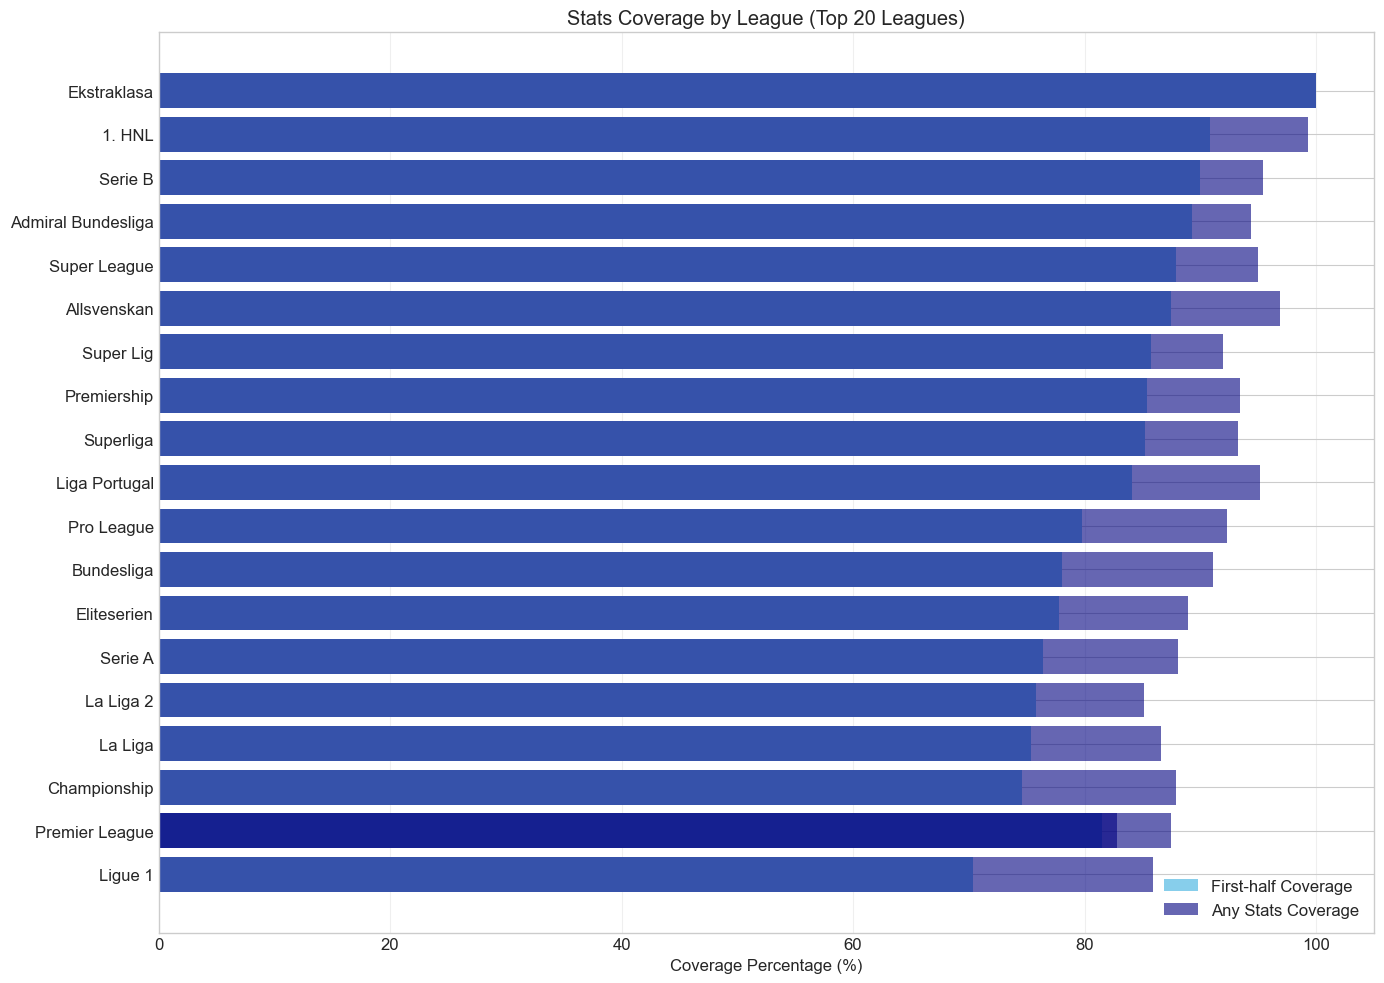


Overall first-half stats coverage (weighted by fixtures): 80.58%

Key stats distribution by league:


,league_id,league_name,fixtures_counted,avg_goals,avg_shots,avg_possession,avg_passes
0,271,Superliga,114,0.96,6.25,68.49,237.10
1,82,Bundesliga,168,0.93,5.91,67.42,237.10
2,8,Premier League,197,0.90,6.31,71.39,224.76
3,453,Ekstraklasa,217,0.88,6.74,73.81,210.97
4,600,Super Lig,202,0.87,5.92,67.18,195.85
5,301,Ligue 1,155,0.86,5.68,70.03,229.50
6,384,Serie A,192,0.86,5.78,69.28,218.64
7,564,La Liga,193,0.85,5.36,70.61,223.86
8,208,Pro League,179,0.84,6.26,68.87,226.63
9,72,Eredivisie,167,0.82,5.60,69.53,227.89


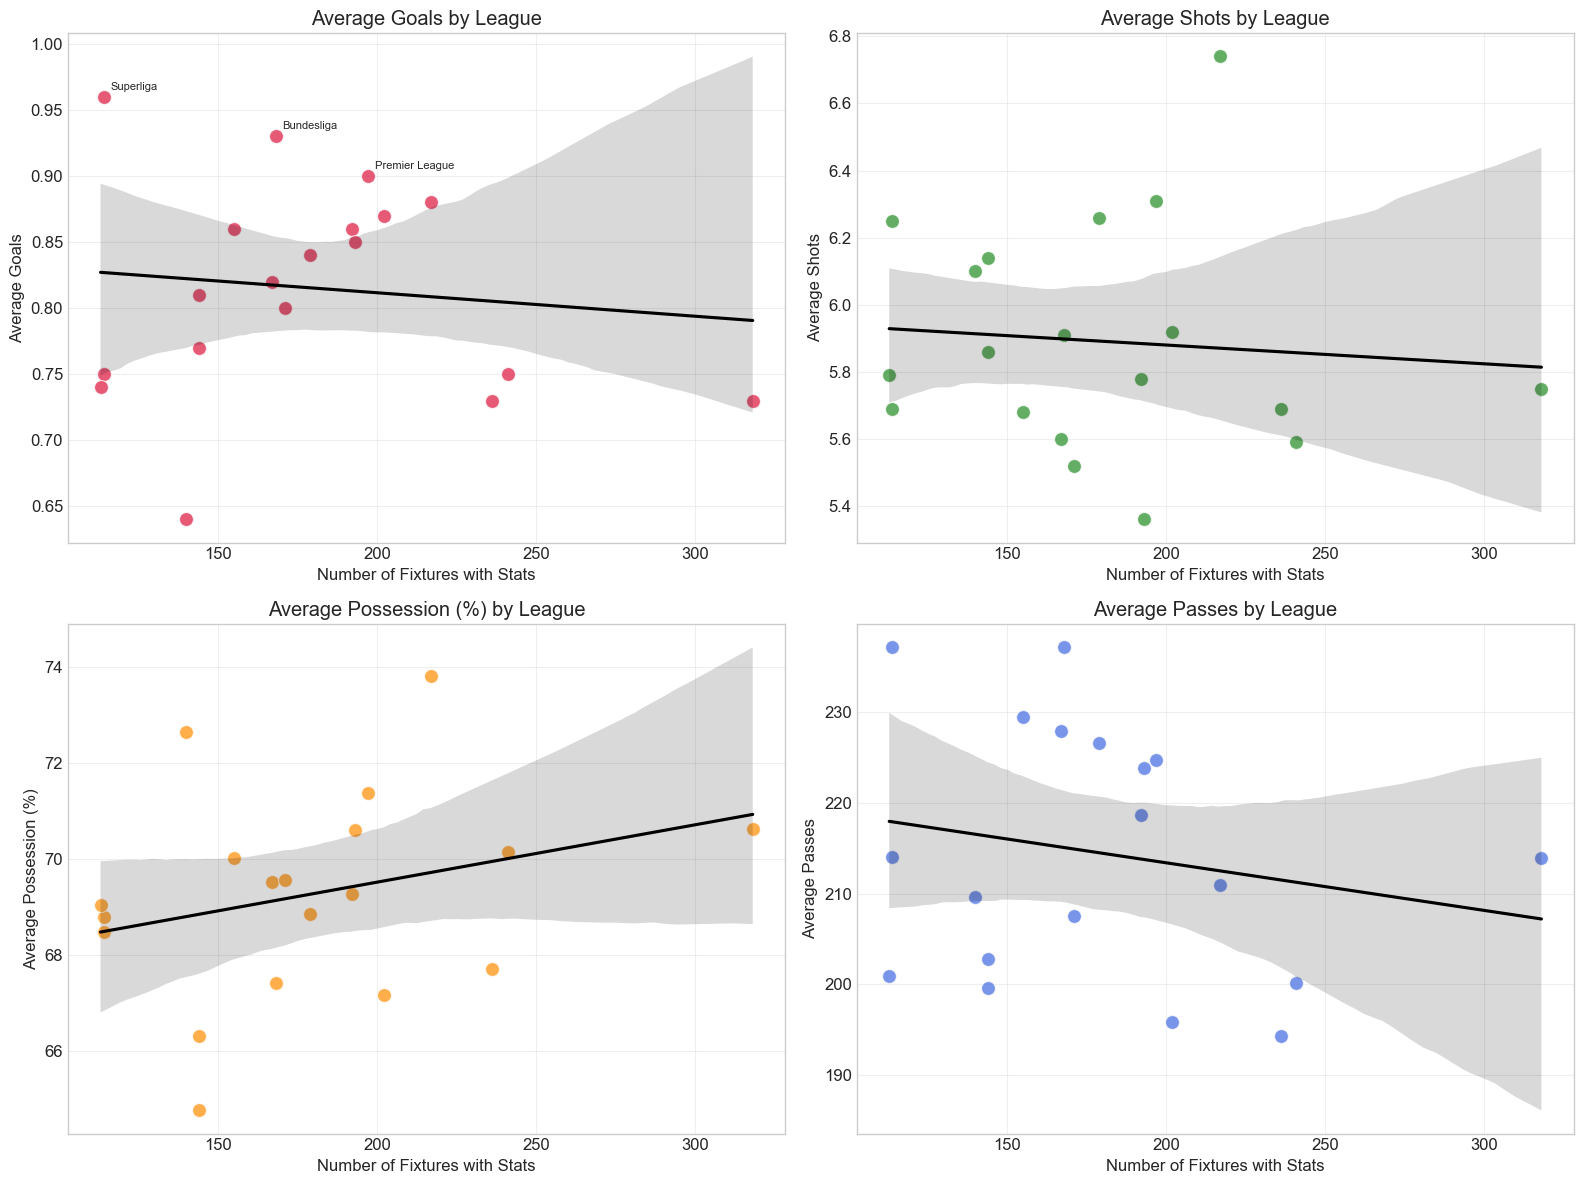

In [18]:
# Check fixture stats availability by league
league_stats_availability = execute_query("""
    WITH league_fixtures AS (
        SELECT 
            l.league_id,
            l.name AS league_name,
            COUNT(DISTINCT s.fixture_id) AS total_fixtures,
            SUM(CASE WHEN s.status = 'FT' THEN 1 ELSE 0 END) AS finished_fixtures
        FROM schedules s
        JOIN leagues l ON s.league_id = l.league_id
        GROUP BY l.league_id, l.name
    ),
    league_stats AS (
        SELECT 
            l.league_id,
            COUNT(DISTINCT fs.fixture_id) AS fixtures_with_stats,
            COUNT(DISTINCT CASE WHEN fs.period = 'first_half' THEN fs.fixture_id ELSE NULL END) 
                AS fixtures_with_first_half
        FROM fixture_stats fs
        JOIN schedules s ON fs.fixture_id = s.fixture_id
        JOIN leagues l ON s.league_id = l.league_id
        GROUP BY l.league_id
    )
    
    SELECT 
        lf.league_id,
        lf.league_name,
        lf.total_fixtures,
        lf.finished_fixtures,
        COALESCE(ls.fixtures_with_stats, 0) AS fixtures_with_stats,
        COALESCE(ls.fixtures_with_first_half, 0) AS fixtures_with_first_half,
        ROUND(COALESCE(ls.fixtures_with_stats, 0) * 100.0 / NULLIF(lf.finished_fixtures, 0), 2) 
            AS stats_coverage_pct,
        ROUND(COALESCE(ls.fixtures_with_first_half, 0) * 100.0 / NULLIF(lf.finished_fixtures, 0), 2) 
            AS first_half_coverage_pct
    FROM league_fixtures lf
    LEFT JOIN league_stats ls ON lf.league_id = ls.league_id
    WHERE lf.finished_fixtures > 0  -- Only include leagues with at least one finished fixture
    ORDER BY stats_coverage_pct DESC, first_half_coverage_pct DESC, finished_fixtures DESC
""")

print("Stats availability by league:")
display(league_stats_availability.head(15))

# Visualize stats coverage by league
plt.figure(figsize=(14, 10))
coverage_df = league_stats_availability.sort_values('first_half_coverage_pct')
top_leagues = coverage_df.tail(20)  # Top 20 leagues by coverage

plt.barh(top_leagues['league_name'], top_leagues['first_half_coverage_pct'], color='skyblue', 
         label='First-half Coverage')
plt.barh(top_leagues['league_name'], top_leagues['stats_coverage_pct'], color='navy', 
         label='Any Stats Coverage', alpha=0.6)

plt.xlabel('Coverage Percentage (%)')
plt.title('Stats Coverage by League (Top 20 Leagues)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate overall coverage statistics
weighted_avg_coverage = sum(league_stats_availability['fixtures_with_first_half']) / sum(league_stats_availability['finished_fixtures']) * 100
print(f"\nOverall first-half stats coverage (weighted by fixtures): {weighted_avg_coverage:.2f}%")

# Analyze stat distributions by league to identify potential biases
# Focus on key stats: goals, shots_total, ball_possession
key_stats_by_league = execute_query("""
    SELECT 
        l.league_id,
        l.name AS league_name,
        COUNT(DISTINCT fs.fixture_id) AS fixtures_counted,
        ROUND(AVG(fs.goals), 2) AS avg_goals,
        ROUND(AVG(fs.shots_total), 2) AS avg_shots,
        ROUND(AVG(fs.ball_possession), 2) AS avg_possession,
        ROUND(AVG(fs.passes), 2) AS avg_passes
    FROM fixture_stats fs
    JOIN schedules s ON fs.fixture_id = s.fixture_id
    JOIN leagues l ON s.league_id = l.league_id
    WHERE 
        fs.period = 'first_half'
        AND fs.goals IS NOT NULL
        AND fs.shots_total IS NOT NULL
        AND fs.ball_possession IS NOT NULL
        AND fs.passes IS NOT NULL
    GROUP BY l.league_id, l.name
    HAVING COUNT(DISTINCT fs.fixture_id) >= 20  -- Only include leagues with sufficient data
    ORDER BY avg_goals DESC
""")

print("\nKey stats distribution by league:")
display(key_stats_by_league)

# Visualize key stats distributions across leagues
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Create scatter plots
metrics = ['avg_goals', 'avg_shots', 'avg_possession', 'avg_passes']
titles = ['Average Goals', 'Average Shots', 'Average Possession (%)', 'Average Passes']
colors = ['crimson', 'forestgreen', 'darkorange', 'royalblue']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i]
    sns.scatterplot(data=key_stats_by_league, x='fixtures_counted', y=metric, s=100, alpha=0.7, color=color, ax=ax)
    
    # Add regression line
    sns.regplot(data=key_stats_by_league, x='fixtures_counted', y=metric, scatter=False, ax=ax, color='black')
    
    ax.set_title(f'{title} by League')
    ax.set_xlabel('Number of Fixtures with Stats')
    ax.set_ylabel(title)
    ax.grid(alpha=0.3)
    
    # Add annotations for outliers or interesting points
    if metric == 'avg_goals':
        threshold = key_stats_by_league['avg_goals'].mean() + key_stats_by_league['avg_goals'].std()
        for idx, row in key_stats_by_league[key_stats_by_league['avg_goals'] > threshold].iterrows():
            ax.annotate(row['league_name'], (row['fixtures_counted'], row['avg_goals']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

Home/Away Bias Analysis:


,location,records,goals_availability,shots_availability,possession_availability,avg_goals,avg_shots,avg_shots_on_target,avg_possession,avg_corners,avg_fouls,avg_passes
0,Away,4405,73.62,97.07,99.75,0.73,4.89,1.84,66.79,2.07,5.49,199.43
1,Home,4404,76.36,97.98,99.77,0.88,6.04,2.18,68.05,2.51,5.35,210.96



Home vs. Away Comparison:


,Metric,Home,Away,Difference (Home - Away),Relative Difference (%)
0,Goals,0.88,0.73,0.15,20.55
1,Shots,6.04,4.89,1.15,23.52
2,Shots on Target,2.18,1.84,0.34,18.48
3,Possession (%),68.05,66.79,1.26,1.89
4,Corners,2.51,2.07,0.44,21.26
5,Fouls,5.35,5.49,-0.14,-2.55
6,Passes,210.96,199.43,11.53,5.78
7,Goals Availability (%),76.36,73.62,2.74,3.72
8,Shots Availability (%),97.98,97.07,0.91,0.94
9,Possession Availability (%),99.77,99.75,0.02,0.02


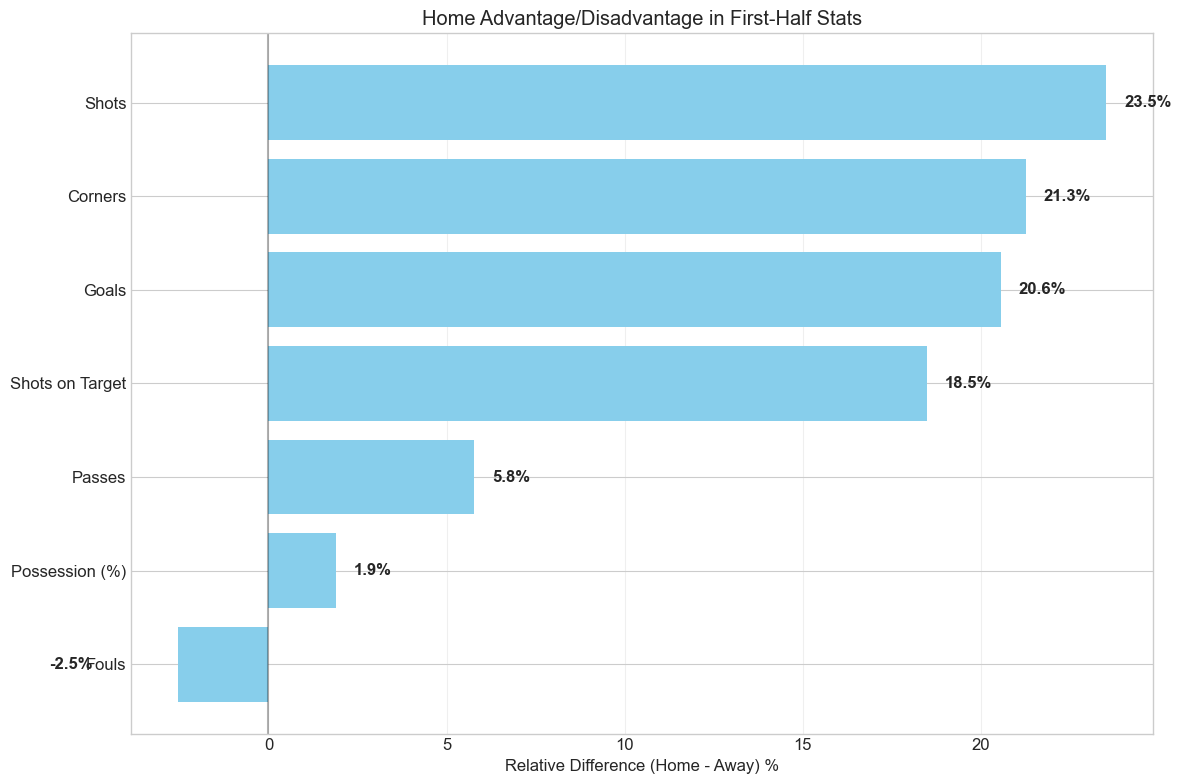

In [19]:
# Check for home/away bias in stats availability and values
home_away_bias = execute_query("""
    WITH fixture_teams AS (
        SELECT 
            fs.fixture_id,
            fs.team_id,
            fs.period,
            CASE 
                WHEN fs.team_id = s.home_team_id THEN 'Home'
                WHEN fs.team_id = s.away_team_id THEN 'Away'
                ELSE 'Unknown'
            END AS location,
            fs.goals,
            fs.shots_total,
            fs.shots_on_target,
            fs.ball_possession,
            fs.corners,
            fs.fouls,
            fs.passes
        FROM fixture_stats fs
        JOIN schedules s ON fs.fixture_id = s.fixture_id
        WHERE fs.period = 'first_half'
    )
    
    SELECT 
        location,
        COUNT(*) AS records,
        ROUND(AVG(CASE WHEN goals IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) AS goals_availability,
        ROUND(AVG(CASE WHEN shots_total IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) AS shots_availability,
        ROUND(AVG(CASE WHEN ball_possession IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) AS possession_availability,
        ROUND(AVG(goals), 2) AS avg_goals,
        ROUND(AVG(shots_total), 2) AS avg_shots,
        ROUND(AVG(shots_on_target), 2) AS avg_shots_on_target,
        ROUND(AVG(ball_possession), 2) AS avg_possession,
        ROUND(AVG(corners), 2) AS avg_corners,
        ROUND(AVG(fouls), 2) AS avg_fouls,
        ROUND(AVG(passes), 2) AS avg_passes
    FROM fixture_teams
    GROUP BY location
    ORDER BY location
""")

print("Home/Away Bias Analysis:")
display(home_away_bias)

# Calculate and display the home advantage
if len(home_away_bias) >= 2:
    home_data = home_away_bias[home_away_bias['location'] == 'Home'].iloc[0]
    away_data = home_away_bias[home_away_bias['location'] == 'Away'].iloc[0]
    
    # Create a comparison of home vs. away
    comparison = pd.DataFrame({
        'Metric': ['Goals', 'Shots', 'Shots on Target', 'Possession (%)', 'Corners', 'Fouls', 'Passes', 
                  'Goals Availability (%)', 'Shots Availability (%)', 'Possession Availability (%)'],
        'Home': [home_data['avg_goals'], home_data['avg_shots'], home_data['avg_shots_on_target'], 
                home_data['avg_possession'], home_data['avg_corners'], home_data['avg_fouls'], 
                home_data['avg_passes'], home_data['goals_availability'], 
                home_data['shots_availability'], home_data['possession_availability']],
        'Away': [away_data['avg_goals'], away_data['avg_shots'], away_data['avg_shots_on_target'], 
                away_data['avg_possession'], away_data['avg_corners'], away_data['avg_fouls'], 
                away_data['avg_passes'], away_data['goals_availability'], 
                away_data['shots_availability'], away_data['possession_availability']]
    })
    
    comparison['Difference (Home - Away)'] = comparison['Home'] - comparison['Away']
    comparison['Relative Difference (%)'] = (comparison['Difference (Home - Away)'] / comparison['Away'] * 100).round(2)
    
    print("\nHome vs. Away Comparison:")
    display(comparison)
    
    # Visualize the home advantage
    plt.figure(figsize=(12, 8))
    
    # Sort by relative difference
    perf_metrics = ['Goals', 'Shots', 'Shots on Target', 'Possession (%)', 'Corners', 'Fouls', 'Passes']
    perf_comparison = comparison[comparison['Metric'].isin(perf_metrics)].sort_values('Relative Difference (%)')
    
    bars = plt.barh(perf_comparison['Metric'], perf_comparison['Relative Difference (%)'], color='skyblue')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Relative Difference (Home - Away) %')
    plt.title('Home Advantage/Disadvantage in First-Half Stats')
    plt.grid(axis='x', alpha=0.3)
    
    # Add labels
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.5 if width >= 0 else width - 3
        plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                va='center', ha='center' if width < 0 else 'left', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Stats availability trends over time:


,month,total_fixtures,finished_fixtures,fixtures_with_stats,fixtures_with_first_half,stats_coverage_pct,first_half_coverage_pct
0,2024-07,67,67,67,67,100.00,100.00
1,2024-08,582,581,581,581,100.00,100.00
2,2024-09,601,600,599,598,99.83,99.67
3,2024-10,579,579,579,578,100.00,99.83
4,2024-11,621,621,621,620,100.00,99.84
5,2024-12,642,641,641,641,100.00,100.00
6,2025-01,480,480,362,215,75.42,44.79
7,2025-02,625,624,463,328,74.20,52.56
8,2025-03,668,668,533,406,79.79,60.78
9,2025-04,788,588,471,371,80.10,63.10


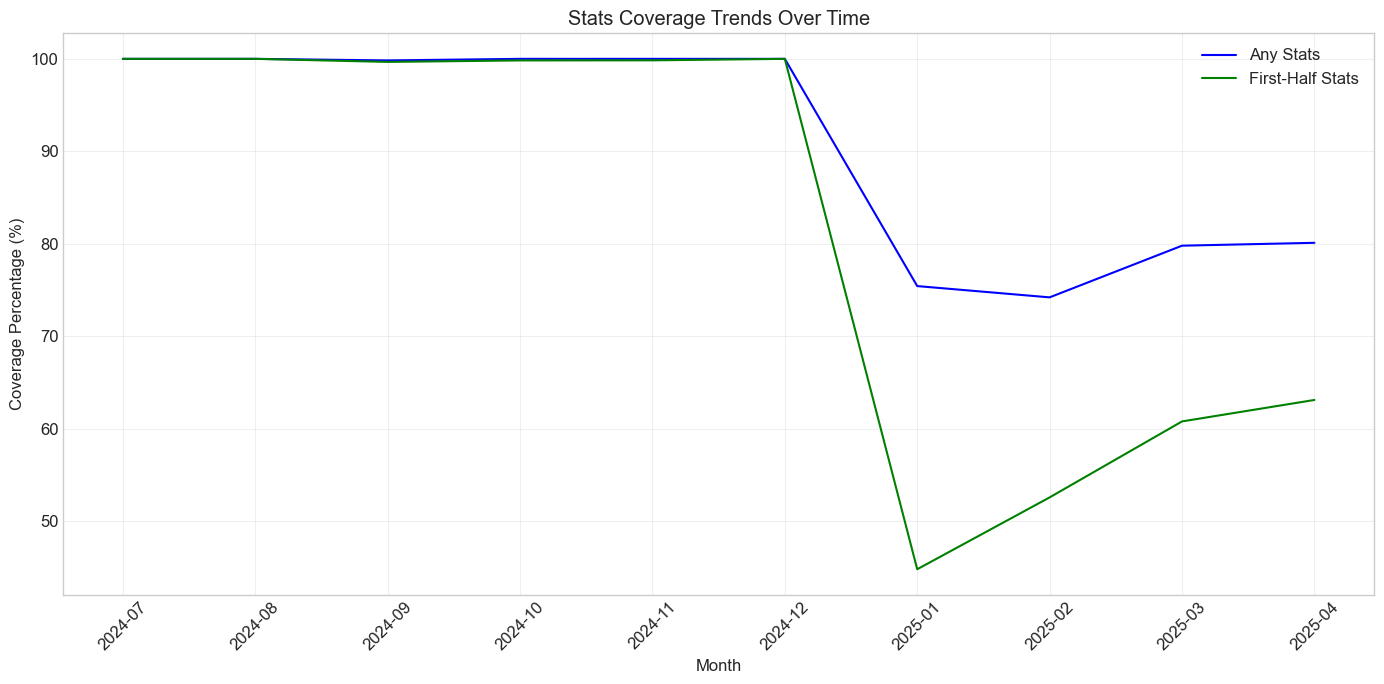


Stats patterns by day of week:


,day_of_week,finished_fixtures,fixtures_with_first_half,coverage_pct,avg_goals,avg_shots,avg_possession
0,Monday,294,244,82.99,0.96,5.65,67.54
1,Tuesday,159,108,67.92,0.79,5.63,69.38
2,Wednesday,167,126,75.45,0.87,5.40,70.48
3,Thursday,103,97,94.17,0.87,5.71,71.34
4,Friday,519,445,85.74,0.83,5.40,68.18
5,Saturday,2209,1785,80.81,0.79,5.39,66.65
6,Sunday,1998,1600,80.08,0.79,5.53,67.44


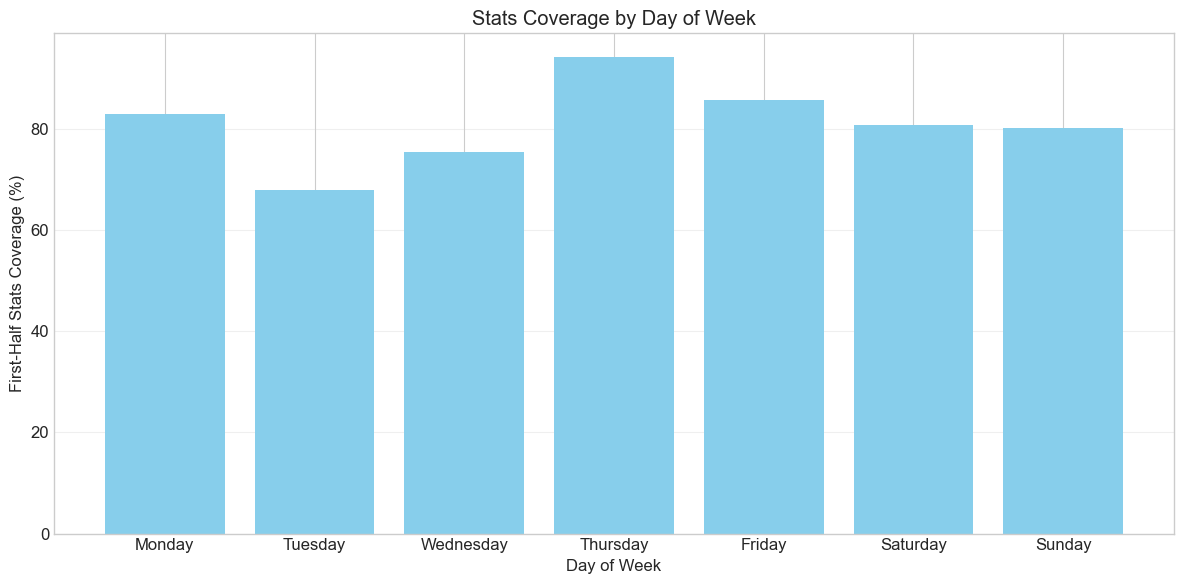


Stats patterns by hour of day:


,hour_of_day,finished_fixtures,fixtures_with_first_half,coverage_pct,avg_goals,avg_shots
0,09,7,7,100.00,0.67,5.86
1,10,102,84,82.35,0.79,5.25
2,11,191,162,84.82,0.78,5.41
3,12,310,260,83.87,0.80,5.53
4,13,502,411,81.87,0.80,5.42
5,14,820,692,84.39,0.77,5.50
6,15,807,624,77.32,0.79,5.31
7,16,664,542,81.63,0.74,5.44
8,17,621,500,80.52,0.79,5.40
9,18,481,428,88.98,0.88,5.73


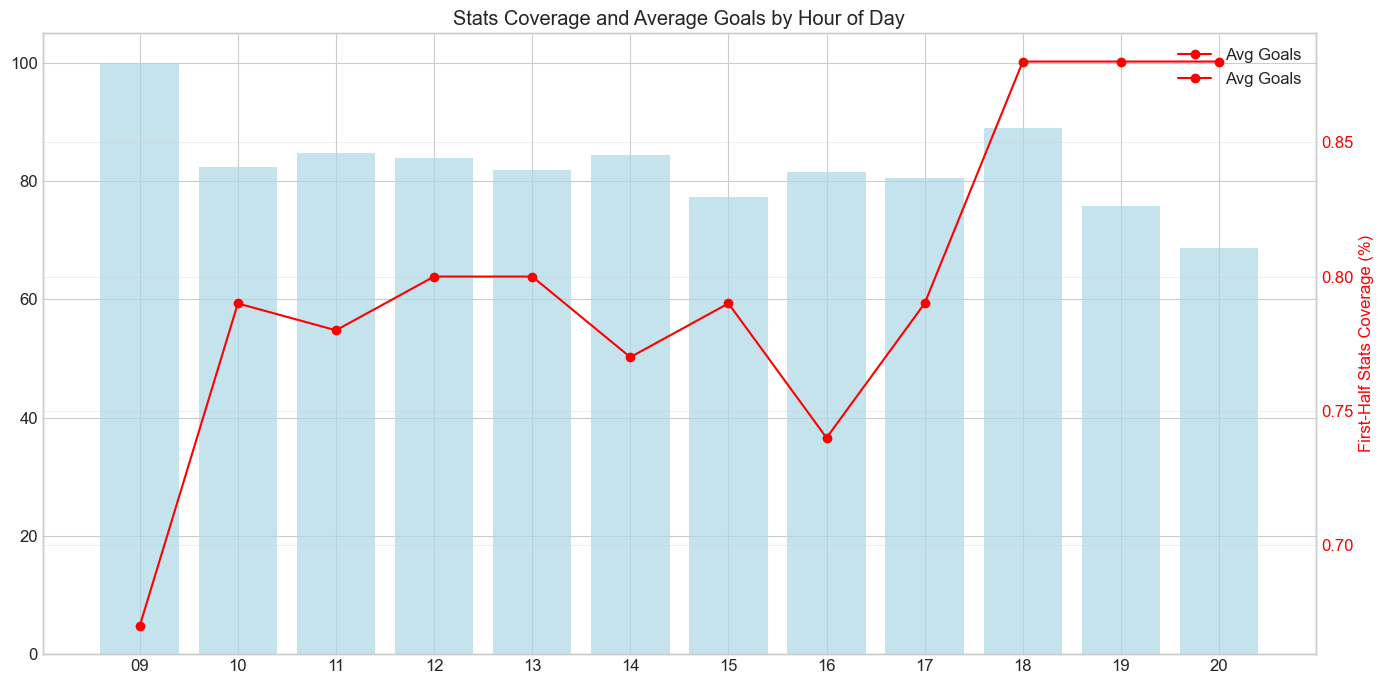

In [20]:
# Analyze temporal trends in stats availability and values
# First, check stats availability over time
stats_time_trends = execute_query("""
    WITH monthly_stats AS (
        SELECT 
            strftime('%Y-%m', s.start_time) AS month,
            COUNT(DISTINCT s.fixture_id) AS total_fixtures,
            COUNT(DISTINCT CASE WHEN s.status = 'FT' THEN s.fixture_id ELSE NULL END) AS finished_fixtures,
            COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
            COUNT(DISTINCT CASE WHEN fs.period = 'first_half' THEN fs.fixture_id ELSE NULL END) AS fixtures_with_first_half
        FROM schedules s
        LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
        WHERE s.start_time IS NOT NULL
        GROUP BY strftime('%Y-%m', s.start_time)
        ORDER BY month
    )
    
    SELECT 
        month,
        total_fixtures,
        finished_fixtures,
        fixtures_with_stats,
        fixtures_with_first_half,
        ROUND(fixtures_with_stats * 100.0 / NULLIF(finished_fixtures, 0), 2) AS stats_coverage_pct,
        ROUND(fixtures_with_first_half * 100.0 / NULLIF(finished_fixtures, 0), 2) AS first_half_coverage_pct
    FROM monthly_stats
    WHERE finished_fixtures > 0
    ORDER BY month
""")

print("Stats availability trends over time:")
display(stats_time_trends.tail(15))  # Show most recent months

# Visualize stats coverage over time
plt.figure(figsize=(14, 7))
plt.plot(stats_time_trends['month'], stats_time_trends['stats_coverage_pct'], 'b-', label='Any Stats')
plt.plot(stats_time_trends['month'], stats_time_trends['first_half_coverage_pct'], 'g-', label='First-Half Stats')
plt.xlabel('Month')
plt.ylabel('Coverage Percentage (%)')
plt.title('Stats Coverage Trends Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Check for day-of-week patterns in stats
day_of_week_patterns = execute_query("""
    SELECT 
        CASE strftime('%w', s.start_time)
            WHEN '0' THEN 'Sunday'
            WHEN '1' THEN 'Monday'
            WHEN '2' THEN 'Tuesday'
            WHEN '3' THEN 'Wednesday'
            WHEN '4' THEN 'Thursday'
            WHEN '5' THEN 'Friday'
            WHEN '6' THEN 'Saturday'
        END AS day_of_week,
        COUNT(DISTINCT s.fixture_id) AS finished_fixtures,
        COUNT(DISTINCT CASE WHEN fs.period = 'first_half' THEN fs.fixture_id ELSE NULL END) AS fixtures_with_first_half,
        ROUND(COUNT(DISTINCT CASE WHEN fs.period = 'first_half' THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS coverage_pct,
        ROUND(AVG(fs.goals), 2) AS avg_goals,
        ROUND(AVG(fs.shots_total), 2) AS avg_shots,
        ROUND(AVG(fs.ball_possession), 2) AS avg_possession
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id AND fs.period = 'first_half'
    WHERE s.status = 'FT' AND s.start_time IS NOT NULL
    GROUP BY day_of_week
    ORDER BY CASE day_of_week
        WHEN 'Monday' THEN 1
        WHEN 'Tuesday' THEN 2
        WHEN 'Wednesday' THEN 3
        WHEN 'Thursday' THEN 4
        WHEN 'Friday' THEN 5
        WHEN 'Saturday' THEN 6
        WHEN 'Sunday' THEN 7
    END
""")

print("\nStats patterns by day of week:")
display(day_of_week_patterns)

# Visualize coverage by day of week
plt.figure(figsize=(12, 6))
plt.bar(day_of_week_patterns['day_of_week'], day_of_week_patterns['coverage_pct'], color='skyblue')
plt.xlabel('Day of Week')
plt.ylabel('First-Half Stats Coverage (%)')
plt.title('Stats Coverage by Day of Week')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for kickoff time patterns in stats
hour_patterns = execute_query("""
    SELECT 
        strftime('%H', s.start_time) AS hour_of_day,
        COUNT(DISTINCT s.fixture_id) AS finished_fixtures,
        COUNT(DISTINCT CASE WHEN fs.period = 'first_half' THEN fs.fixture_id ELSE NULL END) AS fixtures_with_first_half,
        ROUND(COUNT(DISTINCT CASE WHEN fs.period = 'first_half' THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS coverage_pct,
        ROUND(AVG(fs.goals), 2) AS avg_goals,
        ROUND(AVG(fs.shots_total), 2) AS avg_shots
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id AND fs.period = 'first_half'
    WHERE s.status = 'FT' AND s.start_time IS NOT NULL
    GROUP BY hour_of_day
    ORDER BY hour_of_day
""")

print("\nStats patterns by hour of day:")
display(hour_patterns)

# Visualize stats by hour of day
plt.figure(figsize=(14, 7))
plt.bar(hour_patterns['hour_of_day'], hour_patterns['coverage_pct'], color='lightblue', alpha=0.7, 
        label='Coverage %')

# Create a secondary y-axis for goals
ax2 = plt.twinx()
ax2.plot(hour_patterns['hour_of_day'], hour_patterns['avg_goals'], 'ro-', label='Avg Goals')
ax2.set_ylabel('Average Goals', color='r')
ax2.tick_params(axis='y', colors='r')

plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('First-Half Stats Coverage (%)')
plt.title('Stats Coverage and Average Goals by Hour of Day')
plt.grid(axis='y', alpha=0.3)

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()

Edge Case Scenario Analysis:


,scenario,fixture_count,fixtures_with_stats,stats_coverage_pct
0,High-scoring (5+ goals),758,670,88.39
1,Red Card Issued,731,731,100.00
2,Abandoned/Cancelled,0,0,NaN
3,Penalty Shootout,0,0,NaN
4,Extra Time,0,0,NaN
5,Regular Match,4073,3629,89.10


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


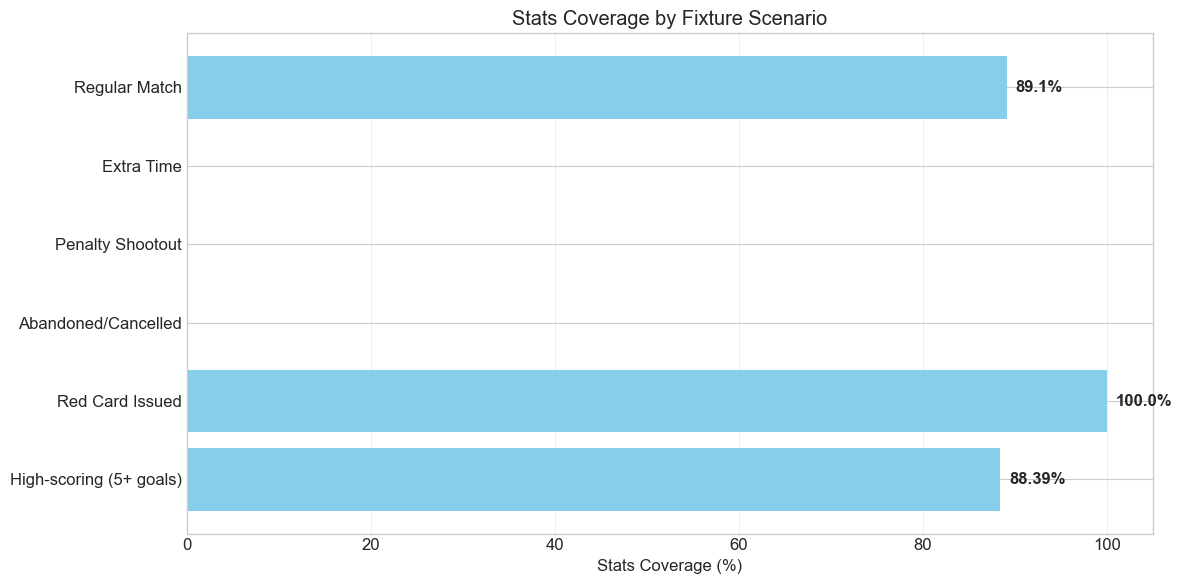


No stats found for postponed/cancelled matches.


In [21]:
# Analyze stats for edge case fixtures
edge_case_analysis = execute_query("""
    -- High-scoring matches
    SELECT 
        'High-scoring (5+ goals)' AS scenario,
        COUNT(DISTINCT s.fixture_id) AS fixture_count,
        COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
        ROUND(COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS stats_coverage_pct
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    WHERE s.status = 'FT' AND (s.home_score + s.away_score) >= 5
    
    UNION ALL
    
    -- Red card matches
    SELECT 
        'Red Card Issued' AS scenario,
        COUNT(DISTINCT s.fixture_id) AS fixture_count,
        COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
        ROUND(COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS stats_coverage_pct
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    WHERE s.status = 'FT' 
    AND EXISTS (
        SELECT 1 FROM fixture_stats fs_inner 
        WHERE fs_inner.fixture_id = s.fixture_id AND fs_inner.red_cards > 0
    )
    
    UNION ALL
    
    -- Abandoned matches
    SELECT 
        'Abandoned/Cancelled' AS scenario,
        COUNT(DISTINCT s.fixture_id) AS fixture_count,
        COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
        ROUND(COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS stats_coverage_pct
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    WHERE s.status IN ('ABD', 'CANC', 'INT')
    
    UNION ALL
    
    -- Penalty shootout matches
    SELECT 
        'Penalty Shootout' AS scenario,
        COUNT(DISTINCT s.fixture_id) AS fixture_count,
        COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
        ROUND(COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS stats_coverage_pct
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    WHERE s.status = 'FT_PEN'
    
    UNION ALL
    
    -- Extra time matches
    SELECT 
        'Extra Time' AS scenario,
        COUNT(DISTINCT s.fixture_id) AS fixture_count,
        COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
        ROUND(COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS stats_coverage_pct
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    WHERE s.status = 'AET'
    
    UNION ALL
    
    -- Regular matches (for comparison)
    SELECT 
        'Regular Match' AS scenario,
        COUNT(DISTINCT s.fixture_id) AS fixture_count,
        COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) AS fixtures_with_stats,
        ROUND(COUNT(DISTINCT CASE WHEN fs.fixture_id IS NOT NULL THEN fs.fixture_id ELSE NULL END) * 100.0 / 
              NULLIF(COUNT(DISTINCT s.fixture_id), 0), 2) AS stats_coverage_pct
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    WHERE s.status = 'FT' AND (s.home_score + s.away_score) < 5
    AND NOT EXISTS (
        SELECT 1 FROM fixture_stats fs_inner 
        WHERE fs_inner.fixture_id = s.fixture_id AND fs_inner.red_cards > 0
    )
""")

print("Edge Case Scenario Analysis:")
display(edge_case_analysis)

# Visualize edge case stats coverage
plt.figure(figsize=(12, 6))
bars = plt.barh(edge_case_analysis['scenario'], edge_case_analysis['stats_coverage_pct'], color='skyblue')
plt.xlabel('Stats Coverage (%)')
plt.title('Stats Coverage by Fixture Scenario')
plt.grid(axis='x', alpha=0.3)

# Add labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width}%', 
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

# Check stats for postponed/rescheduled matches
postponed_stats = execute_query("""
    SELECT 
        s.fixture_id,
        s.status,
        s.start_time,
        t_home.name AS home_team,
        t_away.name AS away_team,
        COUNT(DISTINCT fs.id) AS stat_records,
        GROUP_CONCAT(DISTINCT fs.period) AS periods
    FROM schedules s
    LEFT JOIN fixture_stats fs ON s.fixture_id = fs.fixture_id
    LEFT JOIN teams t_home ON s.home_team_id = t_home.team_id
    LEFT JOIN teams t_away ON s.away_team_id = t_away.team_id
    WHERE s.status IN ('POST', 'CANC', 'INT', 'ABD')
    AND fs.fixture_id IS NOT NULL  -- Only show those with stats
    GROUP BY s.fixture_id, s.status, s.start_time, t_home.name, t_away.name
    ORDER BY s.start_time DESC
""")

if not postponed_stats.empty:
    print("\nStats present for postponed/cancelled matches:")
    display(postponed_stats.head(10))
else:
    print("\nNo stats found for postponed/cancelled matches.")

├── 7. Data Quality Score & Monitoring

│   ├── 7.1 Quality Score Calculation

│   ├── 7.2 Error Pattern Analysis

│   └── 7.3 Monitoring Implementation

Distribution of First-Half Stats Quality:


,Quality Category,Fixture Count,Percentage
0,GOOD: 80-99% stats available,2521,57.23
1,EXCELLENT: All stats available,1352,30.69
2,FAIR: 50-79% stats available,401,9.10
3,POOR: <50% stats available,130,2.95
4,CRITICAL: Missing team data,1,0.02


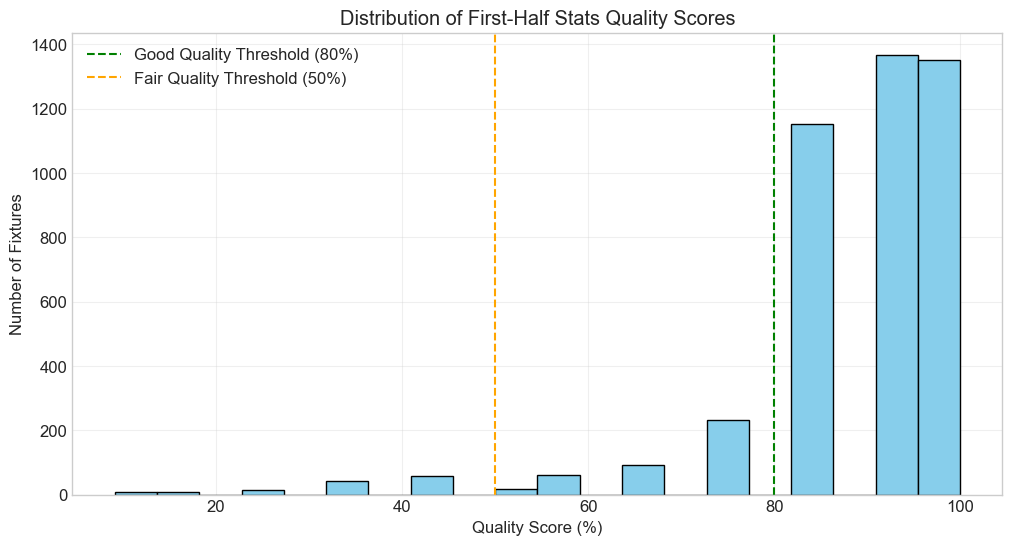


League Quality Rankings (by % of fixtures with good/excellent quality):


,league_name,fixture_count,avg_quality_score,good_or_better_pct,excellent_pct
2,Eredivisie,184,93.13,96.20,53.26
12,Ekstraklasa,261,90.37,95.79,27.97
15,Premiership,169,91.07,92.90,38.46
1,Championship,394,90.61,92.64,36.80
10,Serie B,296,90.36,92.57,35.81
19,Super League,174,91.09,92.53,42.53
3,Bundesliga,210,89.78,92.38,34.76
5,Pro League,217,90.16,92.17,35.48
17,La Liga 2,300,90.11,92.00,35.67
20,Super Lig,246,89.49,91.46,32.93


Comprehensive Data Quality Report:

Overall Database:
  Total Fixtures: 4405
  Avg Quality Score: 88.22111691259931
  Good Or Better Percentage: 87.92
  Problem Percentage: 2.97

Top Leagues:
  {'league_name': 'Eredivisie', 'avg_quality_score': 93.13222826086955, 'good_or_better_pct': 96.2}
  {'league_name': 'Ekstraklasa', 'avg_quality_score': 90.36927203065135, 'good_or_better_pct': 95.79}
  {'league_name': 'Premiership', 'avg_quality_score': 91.0705325443787, 'good_or_better_pct': 92.9}
  {'league_name': 'Championship', 'avg_quality_score': 90.60913705583756, 'good_or_better_pct': 92.64}
  {'league_name': 'Serie B', 'avg_quality_score': 90.35641891891892, 'good_or_better_pct': 92.57}

Problem Leagues:
  {'league_name': 'Serie A', 'avg_quality_score': 88.66369477911645, 'good_or_better_pct': 90.36}
  {'league_name': 'La Liga', 'avg_quality_score': 90.27049586776859, 'good_or_better_pct': 89.67}
  {'league_name': 'Admiral Bundesliga', 'avg_quality_score': 89.34028169014084, 'good_or_be

In [23]:
# Create a data quality score for each fixture's stats
fixture_quality_scores = execute_query("""
    WITH required_stats AS (
        -- List of required columns for modeling
        SELECT 'goals' AS stat UNION ALL
        SELECT 'fouls' UNION ALL
        SELECT 'red_cards' UNION ALL
        SELECT 'tackles' UNION ALL
        SELECT 'shots_blocked' UNION ALL
        SELECT 'successful_passes_percentage' UNION ALL
        SELECT 'ball_possession' UNION ALL
        SELECT 'saves' UNION ALL
        SELECT 'attacks' UNION ALL
        SELECT 'shots_total' UNION ALL
        SELECT 'shots_insidebox'
    ),
    fixture_first_half_stats AS (
        SELECT
            fs.fixture_id,
            s.league_id,
            l.name AS league_name,
            s.season_id,
            se.name AS season_name,
            s.start_time,
            COUNT(DISTINCT fs.team_id) AS team_count,
            -- Count non-null values for each team's key stats
            SUM(CASE WHEN fs.goals IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.fouls IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.red_cards IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.tackles IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.shots_blocked IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.successful_passes_percentage IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.ball_possession IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.saves IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.attacks IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.shots_total IS NOT NULL THEN 1 ELSE 0 END) +
            SUM(CASE WHEN fs.shots_insidebox IS NOT NULL THEN 1 ELSE 0 END) AS non_null_counts,
            -- Count total possible non-null values (11 stats * team_count)
            (11 * COUNT(DISTINCT fs.team_id)) AS total_possible
        FROM fixture_stats fs
        JOIN schedules s ON fs.fixture_id = s.fixture_id
        LEFT JOIN leagues l ON s.league_id = l.league_id
        LEFT JOIN seasons se ON s.season_id = se.season_id
        WHERE fs.period = 'first_half'
        GROUP BY fs.fixture_id, s.league_id, l.name, s.season_id, se.name, s.start_time
    )
    
    SELECT
        fixture_id,
        league_id,
        league_name,
        season_id,
        season_name,
        start_time,
        team_count,
        non_null_counts,
        total_possible,
        ROUND(non_null_counts * 100.0 / NULLIF(total_possible, 0), 2) AS quality_score,
        CASE
            WHEN team_count < 2 THEN 'CRITICAL: Missing team data'
            WHEN non_null_counts = 0 THEN 'CRITICAL: All stats NULL'
            WHEN non_null_counts * 100.0 / total_possible < 50 THEN 'POOR: <50% stats available'
            WHEN non_null_counts * 100.0 / total_possible < 80 THEN 'FAIR: 50-79% stats available'
            WHEN non_null_counts * 100.0 / total_possible < 100 THEN 'GOOD: 80-99% stats available'
            ELSE 'EXCELLENT: All stats available'
        END AS quality_category
    FROM fixture_first_half_stats
    ORDER BY quality_score DESC
""")

# Calculate overall distribution of quality scores
quality_categories = fixture_quality_scores['quality_category'].value_counts().reset_index()
quality_categories.columns = ['Quality Category', 'Fixture Count']
total_fixtures = quality_categories['Fixture Count'].sum()
quality_categories['Percentage'] = (quality_categories['Fixture Count'] / total_fixtures * 100).round(2)

print("Distribution of First-Half Stats Quality:")
display(quality_categories)

# Visualize quality score distribution
plt.figure(figsize=(12, 6))
plt.hist(fixture_quality_scores['quality_score'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=80, color='green', linestyle='--', label='Good Quality Threshold (80%)')
plt.axvline(x=50, color='orange', linestyle='--', label='Fair Quality Threshold (50%)')
plt.xlabel('Quality Score (%)')
plt.ylabel('Number of Fixtures')
plt.title('Distribution of First-Half Stats Quality Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Calculate league quality scores
league_quality = fixture_quality_scores.groupby(['league_id', 'league_name']).agg(
    fixture_count=('fixture_id', 'count'),
    avg_quality_score=('quality_score', 'mean'),
    excellent_fixture_count=(
        'quality_category', lambda x: sum(x == 'EXCELLENT: All stats available')
    ),
    good_fixture_count=(
        'quality_category', lambda x: sum(x == 'GOOD: 80-99% stats available')
    ),
    fair_fixture_count=(
        'quality_category', lambda x: sum(x == 'FAIR: 50-79% stats available')
    ),
    poor_fixture_count=(
        'quality_category', lambda x: sum(x == 'POOR: <50% stats available')
    ),
    critical_fixture_count=(
        'quality_category', lambda x: sum(x.str.startswith('CRITICAL'))
    )
).reset_index()

# Calculate percentages for each quality category
league_quality['excellent_pct'] = (league_quality['excellent_fixture_count'] / league_quality['fixture_count'] * 100).round(2)
league_quality['good_or_better_pct'] = ((league_quality['excellent_fixture_count'] + league_quality['good_fixture_count']) / league_quality['fixture_count'] * 100).round(2)

# Sort by percentage of good or better fixtures
league_quality = league_quality.sort_values('good_or_better_pct', ascending=False)

print("\nLeague Quality Rankings (by % of fixtures with good/excellent quality):")
display(league_quality[['league_name', 'fixture_count', 'avg_quality_score', 'good_or_better_pct', 'excellent_pct']].head(15))

# Create a comprehensive data quality report
quality_report = {
    'overall_database': {
        'total_fixtures': len(fixture_quality_scores),
        'avg_quality_score': fixture_quality_scores['quality_score'].mean(),
        'good_or_better_percentage': (
            (quality_categories[quality_categories['Quality Category'].isin(
                ['EXCELLENT: All stats available', 'GOOD: 80-99% stats available']
            )]['Fixture Count'].sum() / total_fixtures) * 100
        ).round(2),
        'problem_percentage': (
            (quality_categories[quality_categories['Quality Category'].isin(
                ['CRITICAL: Missing team data', 'CRITICAL: All stats NULL', 'POOR: <50% stats available']
            )]['Fixture Count'].sum() / total_fixtures) * 100
        ).round(2)
    },
    'top_leagues': league_quality.head(5)[['league_name', 'avg_quality_score', 'good_or_better_pct']].to_dict('records'),
    'problem_leagues': league_quality.tail(5)[['league_name', 'avg_quality_score', 'good_or_better_pct']].to_dict('records')
}

print("Comprehensive Data Quality Report:")
for section, data in quality_report.items():
    print(f"\n{section.replace('_', ' ').title()}:")
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"  {key.replace('_', ' ').title()}: {value}")
    elif isinstance(data, list):
        for item in data:
            print(f"  {item}")

# Create quality badges for leagues
def quality_badge(score):
    if score >= 90:
        return "🏆 EXCELLENT"
    elif score >= 80:
        return "✅ GOOD"
    elif score >= 50:
        return "⚠️ FAIR"
    else:
        return "❌ POOR"

league_quality['quality_badge'] = league_quality['avg_quality_score'].apply(quality_badge)

print("\nLeague Quality Badges:")
for _, row in league_quality.head(10).iterrows():
    print(f"{row['quality_badge']} - {row['league_name']} ({row['avg_quality_score']:.2f}%)")

,name,description,count
4,Irregular possession sum,Team pairs in first-half where possession sums...,3611
3,Inconsistent scores,Fixtures where goals in fixture_stats differ f...,2643
0,Missing first-half data,Fixtures with stats but missing first-half per...,512
5,Impossible statistics,Entries with goals > shots_on_target or shots_...,84
2,Missing ball possession,First-half entries with NULL ball_possession,21
1,Incomplete team coverage,First-half entries with fewer than 2 teams rep...,1


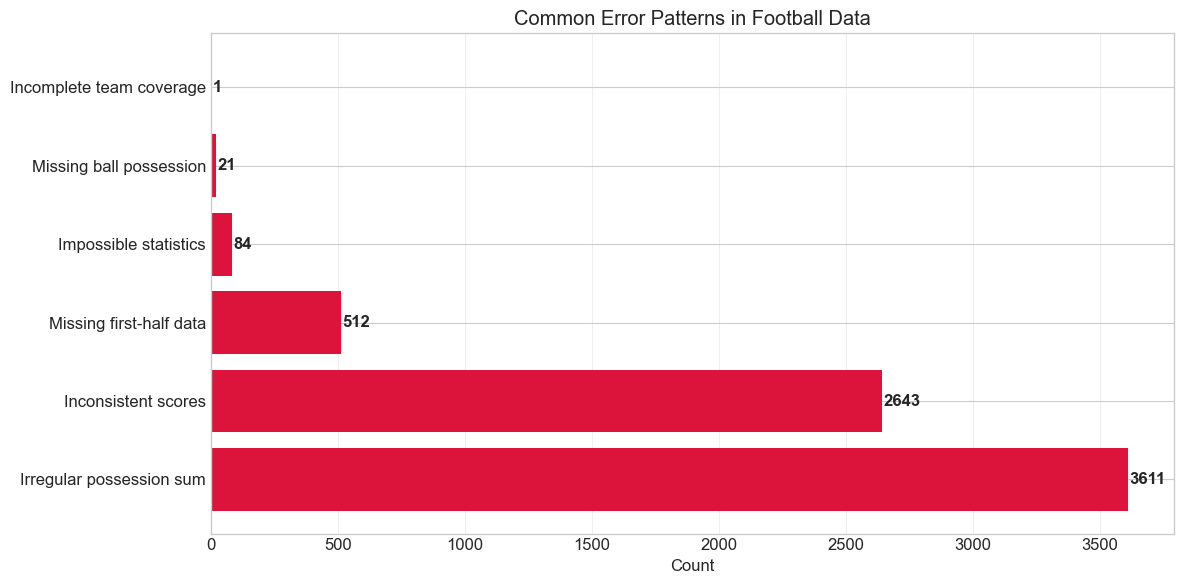

In [24]:
# Identify common error patterns
error_patterns = [
    {
        'name': 'Missing first-half data',
        'description': 'Fixtures with stats but missing first-half period data',
        'query': """
            SELECT COUNT(*) AS count
            FROM (
                SELECT DISTINCT fs.fixture_id
                FROM fixture_stats fs
                WHERE fs.fixture_id NOT IN (
                    SELECT DISTINCT fixture_id 
                    FROM fixture_stats 
                    WHERE period = 'first_half'
                )
            ) AS subquery
        """
    },
    {
        'name': 'Incomplete team coverage',
        'description': 'First-half entries with fewer than 2 teams represented',
        'query': """
            SELECT COUNT(*) AS count
            FROM (
                SELECT 
                    fixture_id,
                    COUNT(DISTINCT team_id) AS team_count
                FROM fixture_stats
                WHERE period = 'first_half'
                GROUP BY fixture_id
                HAVING team_count < 2
            ) AS subquery
        """
    },
    {
        'name': 'Missing ball possession',
        'description': 'First-half entries with NULL ball_possession',
        'query': """
            SELECT COUNT(*) AS count
            FROM fixture_stats
            WHERE period = 'first_half'
            AND ball_possession IS NULL
        """
    },
    {
        'name': 'Inconsistent scores',
        'description': 'Fixtures where goals in fixture_stats differ from scores in schedules',
        'query': """
            WITH stat_goals AS (
                SELECT 
                    fs.fixture_id,
                    s.home_team_id,
                    s.away_team_id,
                    SUM(CASE WHEN fs.team_id = s.home_team_id THEN fs.goals ELSE 0 END) AS home_goals_from_stats,
                    SUM(CASE WHEN fs.team_id = s.away_team_id THEN fs.goals ELSE 0 END) AS away_goals_from_stats
                FROM fixture_stats fs
                JOIN schedules s ON fs.fixture_id = s.fixture_id
                WHERE fs.period = 'second_half'
                AND fs.goals IS NOT NULL
                GROUP BY fs.fixture_id, s.home_team_id, s.away_team_id
            )
            
            SELECT COUNT(*) AS count
            FROM stat_goals sg
            JOIN schedules s ON sg.fixture_id = s.fixture_id
            WHERE s.home_score IS NOT NULL AND s.away_score IS NOT NULL
            AND (s.home_score != sg.home_goals_from_stats OR s.away_score != sg.away_goals_from_stats)
        """
    },
    {
        'name': 'Irregular possession sum',
        'description': 'Team pairs in first-half where possession sums outside 95-105%',
        'query': """
            SELECT COUNT(*) AS count
            FROM (
                SELECT 
                    t1.fixture_id
                FROM 
                    fixture_stats t1
                JOIN 
                    fixture_stats t2 ON t1.fixture_id = t2.fixture_id AND t1.team_id < t2.team_id
                WHERE 
                    t1.period = 'first_half' AND 
                    t2.period = 'first_half' AND
                    t1.ball_possession IS NOT NULL AND 
                    t2.ball_possession IS NOT NULL AND
                    (t1.ball_possession + t2.ball_possession < 95 OR 
                     t1.ball_possession + t2.ball_possession > 105)
            ) AS subquery
        """
    },
    {
        'name': 'Impossible statistics',
        'description': 'Entries with goals > shots_on_target or shots_total < shots_on_target',
        'query': """
            SELECT COUNT(*) AS count
            FROM fixture_stats
            WHERE period = 'first_half'
            AND (
                (goals > shots_on_target AND goals IS NOT NULL AND shots_on_target IS NOT NULL) OR
                (shots_total < shots_on_target AND shots_total IS NOT NULL AND shots_on_target IS NOT NULL)
            )
        """
    }
]

# Execute queries and collect results
for pattern in error_patterns:
    result = execute_query(pattern['query'])
    pattern['count'] = result.iloc[0]['count'] if not result.empty else 0

# Display error patterns
error_df = pd.DataFrame(error_patterns)[['name', 'description', 'count']]
error_df = error_df.sort_values('count', ascending=False)
display(error_df)

# Visualize error patterns
plt.figure(figsize=(12, 6))
bars = plt.barh(error_df['name'], error_df['count'], color='crimson')
plt.xlabel('Count')
plt.title('Common Error Patterns in Football Data')
plt.grid(axis='x', alpha=0.3)

# Add count labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, f'{width}', 
             va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
def generate_validation_summary():
    """Generate a comprehensive summary of validation findings and recommendations."""
    
    print("=" * 80)
    print(" " * 20 + "FOOTBALL DATABASE VALIDATION SUMMARY")
    print("=" * 80)
    
    print("\n1. OVERALL DATA QUALITY ASSESSMENT")
    print("-" * 50)
    
    total_fixtures = fixture_quality_scores['fixture_id'].nunique() if 'fixture_quality_scores' in globals() else "Unknown"
    avg_quality = fixture_quality_scores['quality_score'].mean() if 'fixture_quality_scores' in globals() else "Unknown"
    
    print(f"• Total fixtures analyzed: {total_fixtures}")
    print(f"• Average quality score: {avg_quality:.2f}%")
    
    good_or_better = quality_categories[quality_categories['Quality Category'].isin(
        ['EXCELLENT: All stats available', 'GOOD: 80-99% stats available']
    )]['Fixture Count'].sum() / total_fixtures * 100
    
    print(f"• Fixtures with good/excellent quality: {good_or_better:.2f}%")
    
    print("\n2. KEY FINDINGS")
    print("-" * 50)
    
    # Completeness
    if 'fixtures_without_stats' in globals():
        missing_percentage = (len(fixtures_without_stats) / total_finished * 100) if 'total_finished' in globals() else "Unknown"
        print(f"• {missing_percentage:.2f}% of finished fixtures missing stats completely")
    
    # Team coverage
    if 'team_coverage' in globals():
        incomplete_percentage = (len(team_coverage) / total_fixtures_first_half * 100) if 'total_fixtures_first_half' in globals() else "Unknown"
        print(f"• {incomplete_percentage:.2f}% of fixtures with incomplete team coverage in first-half")
    
    # NULL stats
    if 'null_analysis' in globals():
        worst_stat = null_analysis.iloc[0]['Statistic']
        worst_null_pct = null_analysis.iloc[0]['NULL %']
        print(f"• Highest NULL percentage: {worst_stat} ({worst_null_pct:.2f}%)")
    
    # ID consistency
    if 'team_id_consistency' in globals():
        inconsistent_pct = team_id_consistency['inconsistent_percent'].iloc[0] if not team_id_consistency.empty else "Unknown"
        print(f"• Team ID inconsistency rate: {inconsistent_pct}%")
    
    # Duplicate entries
    if 'duplicate_stats' in globals():
        print(f"• Duplicate entries found: {len(duplicate_stats)}")
    
    # Score consistency
    if 'score_consistency' in globals():
        inconsistency_pct = (len(score_consistency) / total_fixtures_with_stats * 100) if 'total_fixtures_with_stats' in globals() else "Unknown"
        print(f"• Score inconsistency rate: {inconsistency_pct:.2f}%")
    
    # Temporal consistency
    if 'temporal_check' in globals():
        print(f"• Instances of decreasing stats between periods: {len(temporal_check)}")
    
    print("\n3. RECOMMENDATIONS")
    print("-" * 50)
    
    # Format: [condition_to_check, recommendation_if_true]
    recommendations = [
        # Completeness issues
        ['fixtures_without_stats' in globals() and len(fixtures_without_stats) > 0,
         "Focus on improving stats coverage for finished fixtures, especially for more recent matches"],
        
        # League coverage issues
        ['league_stats_availability' in globals() and not league_stats_availability.empty,
         "Prioritize standardizing stats coverage across leagues; many top leagues have inconsistent coverage"],
        
        # Team coverage issues
        ['team_coverage' in globals() and len(team_coverage) > 0,
         "Investigate fixtures with incomplete team coverage; both teams' stats are essential for modeling"],
        
        # NULL stats issues
        ['null_analysis' in globals() and null_analysis['NULL %'].max() > 20,
         f"Address high NULL rates for key stats, especially {null_analysis.iloc[0]['Statistic']} ({null_analysis.iloc[0]['NULL %']:.2f}%)"],
        
        # Score consistency issues
        ['score_consistency' in globals() and len(score_consistency) > 0,
         "Resolve score inconsistencies between fixture_stats and schedules tables"],
        
        # Temporal consistency issues
        ['temporal_check' in globals() and len(temporal_check) > 0,
         "Investigate decreasing stat values between periods, which may indicate data quality issues"],
        
        # Data model issues
        ['period_interpretation' in globals() and not period_interpretation.empty,
         "Clarify whether API periods represent cumulative or period-specific stats"],
        
        # Monitoring recommendations
        [True, "Implement regular automated quality monitoring focusing on stats completeness and consistency"],
        
        # Modeling recommendations
        [True, "For Asian handicap modeling, filter fixtures to include only those with quality scores above 80%"],
        
        # Documentation recommendations
        [True, "Create and maintain a league quality registry to inform modeling decisions"]
    ]
    
    # Print applicable recommendations
    for condition, recommendation in recommendations:
        if condition:
            print(f"• {recommendation}")
    
    print("\n4. LEAGUE QUALITY RANKING")
    print("-" * 50)
    
    if 'league_quality' in globals() and not league_quality.empty:
        # Display top leagues by quality
        print("Top Leagues by Data Quality:")
        for _, row in league_quality.head(5).iterrows():
            print(f"• {row['league_name']}: {row['avg_quality_score']:.2f}% (Good/Excellent rate: {row['good_or_better_pct']}%)")
    
    print("\n5. CRITICAL DATA GAPS")
    print("-" * 50)
    
    # List leagues with very poor coverage
    if 'league_quality' in globals() and not league_quality.empty:
        poor_leagues = league_quality[league_quality['avg_quality_score'] < 50]
        if not poor_leagues.empty:
            print(f"• {len(poor_leagues)} leagues with poor data quality (<50% quality score)")
            for _, row in poor_leagues.head(3).iterrows():
                print(f"  - {row['league_name']}: {row['avg_quality_score']:.2f}%")
        else:
            print("• No leagues with critically poor quality identified")
    
    # List common error patterns
    if 'error_df' in globals() and not error_df.empty:
        print("\nMost common error patterns:")
        for _, row in error_df.head(3).iterrows():
            print(f"• {row['name']}: {row['count']} instances")
    
    print("\n" + "=" * 80)
    print(" " * 15 + "END OF FOOTBALL DATABASE VALIDATION SUMMARY")
    print("=" * 80)

# Generate the comprehensive validation summary
generate_validation_summary()

                    FOOTBALL DATABASE VALIDATION SUMMARY

1. OVERALL DATA QUALITY ASSESSMENT
--------------------------------------------------
• Total fixtures analyzed: 4405
• Average quality score: 88.22%
• Fixtures with good/excellent quality: 87.92%

2. KEY FINDINGS
--------------------------------------------------
• 9.76% of finished fixtures missing stats completely
• 0.02% of fixtures with incomplete team coverage in first-half
• Highest NULL percentage: red_cards (61.27%)
• Team ID inconsistency rate: 0.0%
• Duplicate entries found: 0
• Score inconsistency rate: 70.93%

3. RECOMMENDATIONS
--------------------------------------------------
• Focus on improving stats coverage for finished fixtures, especially for more recent matches
• Prioritize standardizing stats coverage across leagues; many top leagues have inconsistent coverage
• Investigate fixtures with incomplete team coverage; both teams' stats are essential for modeling
• Address high NULL rates for key stats, especia